In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from itertools import product
import json
import copy

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# 3.1 Explorarea datelor

## Citirea datelor si preprocesarea datelor

### Setul PTB

In [2]:
ptbdb_normal = pd.read_csv('ptbdb_normal.csv', header=None)
ptbdb_normal.columns = [f't{i}' for i in range(ptbdb_normal.shape[1] - 1)] + ['target']
ptbdb_abnormal = pd.read_csv('ptbdb_abnormal.csv', header=None)
ptbdb_abnormal.columns = [f't{i}' for i in range(ptbdb_abnormal.shape[1] - 1)] + ['target']


ptbdb = pd.concat([ptbdb_normal, ptbdb_abnormal])
shuffled_ptbdb = ptbdb.sample(frac=1)

ptbdb_target_labels = \
    {
        0: 'Normal',
        1: 'Abnormal'
    }

In [3]:
shuffled_ptbdb.describe()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t178,t179,t180,t181,t182,t183,t184,t185,t186,target
count,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,...,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.0,14552.000000
mean,0.976637,0.721663,0.403099,0.242893,0.207218,0.216453,0.221752,0.224486,0.227349,0.229704,...,0.001190,0.001133,0.000900,0.000739,0.000661,0.000475,0.000177,0.000185,0.0,0.721963
std,0.034532,0.195690,0.249794,0.249519,0.218097,0.192412,0.180740,0.176943,0.176674,0.176579,...,0.021361,0.021012,0.017316,0.014640,0.014033,0.012289,0.006545,0.006835,0.0,0.448047
min,0.624227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.959377,0.584589,0.212300,0.052269,0.061875,0.090487,0.096503,0.097095,0.097231,0.097144,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.000000,0.740148,0.371911,0.168148,0.136082,0.159451,0.167479,0.171541,0.177380,0.180337,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,1.000000,0.881483,0.557785,0.336232,0.264104,0.264633,0.286484,0.302255,0.311664,0.325292,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985523,0.993213,0.997738,...,0.791899,0.773743,0.789804,0.628177,0.602033,0.644880,0.371502,0.376668,0.0,1.000000


### Setul Patients

In [4]:
patientsdb = pd.read_csv('patients.csv')

patients_numeric_features = ['Regular_fiber_diet', 'Sedentary_hours_daily', 'Age', 'Est_avg_calorie_intake', 'Main_meals_daily', 
                             'Height', 'Water_daily', 'Weight', 'Physical_activity_level', 'Technology_time_use']
patients_string_features = ['Transportation', 'Alcohol', 'Snacks', 'Gender']
patients_bool_feature = ['Diagnostic_in_family_history', 'High_calorie_diet', 'Smoker', 'Calorie_monitoring']
patients_class_feature = ['Diagnostic']

for feature in patients_numeric_features:
    if patientsdb[feature].dtype == type(object):
        patientsdb[feature] = patientsdb[feature].str.replace(',', '.').astype(float)

In [5]:
patientsdb.describe()

,Regular_fiber_diet,Sedentary_hours_daily,Age,Est_avg_calorie_intake,Main_meals_daily,Height,Water_daily,Weight,Physical_activity_level,Technology_time_use
count,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000,1921.000000
mean,3.844937,3.693571,44.792506,2253.687663,2.683472,3.573488,2.010367,205.637344,1.012640,1.345653
std,62.439617,21.759835,633.311837,434.075794,0.779179,58.098160,0.611034,3225.653536,0.855526,29.789928
min,1.000000,2.210000,15.000000,1500.000000,1.000000,1.450000,1.000000,-1.000000,0.000000,0.000000
25%,2.000000,2.770000,19.971660,1871.000000,2.658639,1.630000,1.606076,58.830710,0.115974,0.000000
50%,2.387426,3.130000,22.829753,2253.000000,3.000000,1.700000,2.000000,80.386078,1.000000,1.000000
75%,3.000000,3.640000,26.000000,2628.000000,3.000000,1.770000,2.480555,105.036075,1.683497,1.000000
max,2739.000000,956.580000,19685.000000,3000.000000,4.000000,1915.000000,3.000000,82628.000000,3.000000,1306.000000


In [6]:
preprocessed_patients = patientsdb.copy()

for feature in patients_string_features + patients_bool_feature + patients_class_feature:
        le = LabelEncoder()
        preprocessed_patients[feature] = le.fit_transform(preprocessed_patients[feature])

imputer = SimpleImputer(strategy='mean', missing_values=-1)
preprocessed_patients['Weight'] = imputer.fit_transform(preprocessed_patients[['Weight']])

for feature in patients_numeric_features:
    q1 = preprocessed_patients[feature].quantile(0.25)
    q3 = preprocessed_patients[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    preprocessed_patients = preprocessed_patients[(preprocessed_patients[feature] > lower_bound) & (preprocessed_patients[feature] < upper_bound)]

scaled_patients = preprocessed_patients.copy()
for feature in patients_numeric_features:
    scaler = MinMaxScaler()
    scaled_patients[feature] = scaler.fit_transform(scaled_patients[[feature]])

In [7]:
preprocessed_patients.describe()

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
count,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000
mean,2.563107,2.449869,0.849956,0.883495,3.227643,23.185864,2.210944,2253.869373,2.967056,1.876434,1.714828,0.020300,2.056328,0.044131,92.245200,1.033301,0.707855,0.514563,3.464254
std,1.104415,0.551723,0.357272,0.320971,0.557054,4.199217,0.476093,433.653736,0.150543,0.406116,0.086865,0.141087,0.605251,0.205476,27.366728,0.863269,0.651378,0.500009,2.061725
min,0.000000,1.000000,0.000000,0.000000,2.210000,15.000000,1.000000,1500.000000,2.217651,0.000000,1.460000,0.000000,1.000000,0.000000,39.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,1.000000,1.000000,2.840000,19.821996,2.000000,1868.000000,3.000000,2.000000,1.650000,0.000000,1.699971,0.000000,70.000000,0.115974,0.000000,0.000000,2.000000
50%,3.000000,2.512719,1.000000,1.000000,3.180000,22.882558,2.000000,2257.000000,3.000000,2.000000,1.710000,0.000000,2.000000,0.000000,90.032671,1.000000,1.000000,1.000000,4.000000
75%,3.000000,3.000000,1.000000,1.000000,3.640000,25.994393,2.000000,2633.000000,3.000000,2.000000,1.780000,0.000000,2.556068,0.000000,112.555456,1.661556,1.000000,1.000000,5.000000
max,4.000000,3.000000,1.000000,1.000000,4.660000,35.000000,3.000000,2998.000000,3.452590,3.000000,1.940000,1.000000,3.000000,1.000000,165.057269,3.000000,2.000000,1.000000,6.000000


In [8]:
scaled_patients.describe()

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
count,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000
mean,2.563107,0.724935,0.849956,0.883495,0.415365,0.409293,2.210944,0.503251,0.606835,1.876434,0.530891,0.020300,0.528164,0.044131,0.422389,0.344434,0.353928,0.514563,3.464254
std,1.104415,0.275862,0.357272,0.320971,0.227369,0.209961,0.476093,0.289488,0.121903,0.406116,0.180968,0.141087,0.302625,0.205476,0.217098,0.287756,0.325689,0.500009,2.061725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.500000,1.000000,1.000000,0.257143,0.241100,2.000000,0.245661,0.633512,2.000000,0.395833,0.000000,0.349985,0.000000,0.245920,0.038658,0.000000,0.000000,2.000000
50%,3.000000,0.756360,1.000000,1.000000,0.395918,0.394128,2.000000,0.505340,0.633512,2.000000,0.520833,0.000000,0.500000,0.000000,0.404837,0.333333,0.500000,1.000000,4.000000
75%,3.000000,1.000000,1.000000,1.000000,0.583673,0.549720,2.000000,0.756342,0.633512,2.000000,0.666667,0.000000,0.778034,0.000000,0.583508,0.553852,0.500000,1.000000,5.000000
max,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


### Setul MitBi

In [9]:
mitbih_train = pd.read_csv('mitbih_train.csv', header=None)
mitbih_train.columns = [f't{i}' for i in range(mitbih_train.shape[1] - 1)] + ['target']
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)
mitbih_test.columns = [f't{i}' for i in range(mitbih_test.shape[1] - 1)] + ['target']

mitbih = pd.concat([mitbih_train, mitbih_test])
shuffled_mitbih = mitbih.sample(frac=1)

mitbih_target_labels = \
    {
        0: 'Normal',
        1: 'Supraventricular',
        2: 'Ventricular',
        3: 'Fusion',
        4: 'Unknown'
    }

## Diagrame

### Grafice pentru distributia claselor

Text(0, 0.5, 'Count')

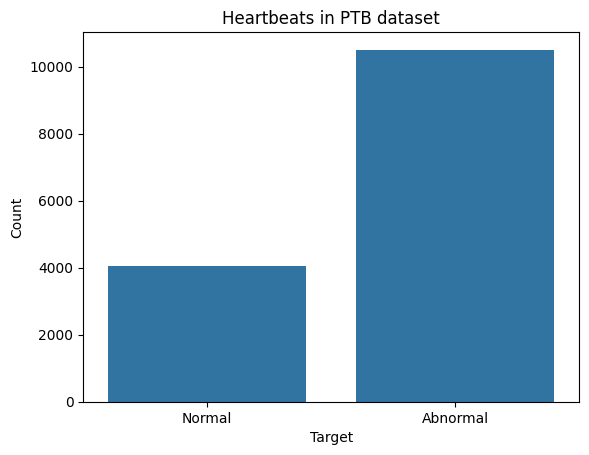

In [10]:
axes = sns.countplot(x='target', data=shuffled_ptbdb)
axes.set_xticks(ticks=[0, 1], labels=[ptbdb_target_labels[0], ptbdb_target_labels[1]])
axes.set_title('Heartbeats in PTB dataset')
axes.set_xlabel('Target')
axes.set_ylabel('Count')

Text(0, 0.5, 'Count')

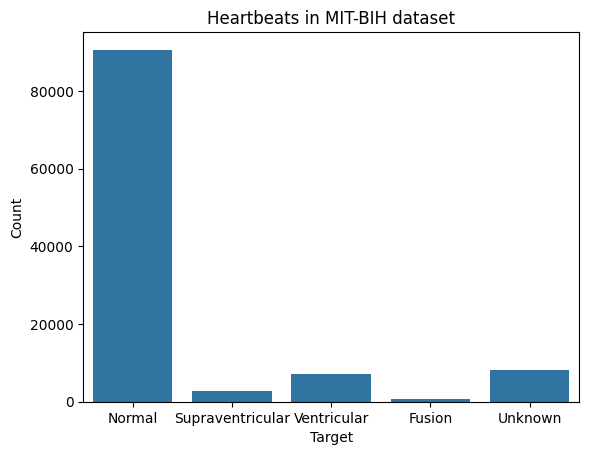

In [11]:
axes = sns.countplot(x='target', data=shuffled_mitbih)
axes.set_xticks(ticks=[0, 1, 2, 3, 4], labels=[mitbih_target_labels[0], mitbih_target_labels[1], mitbih_target_labels[2], mitbih_target_labels[3], mitbih_target_labels[4]])
axes.set_title('Heartbeats in MIT-BIH dataset')
axes.set_xlabel('Target')
axes.set_ylabel('Count')

### Grafice pentru exemplificarea fiecarui tip de problema

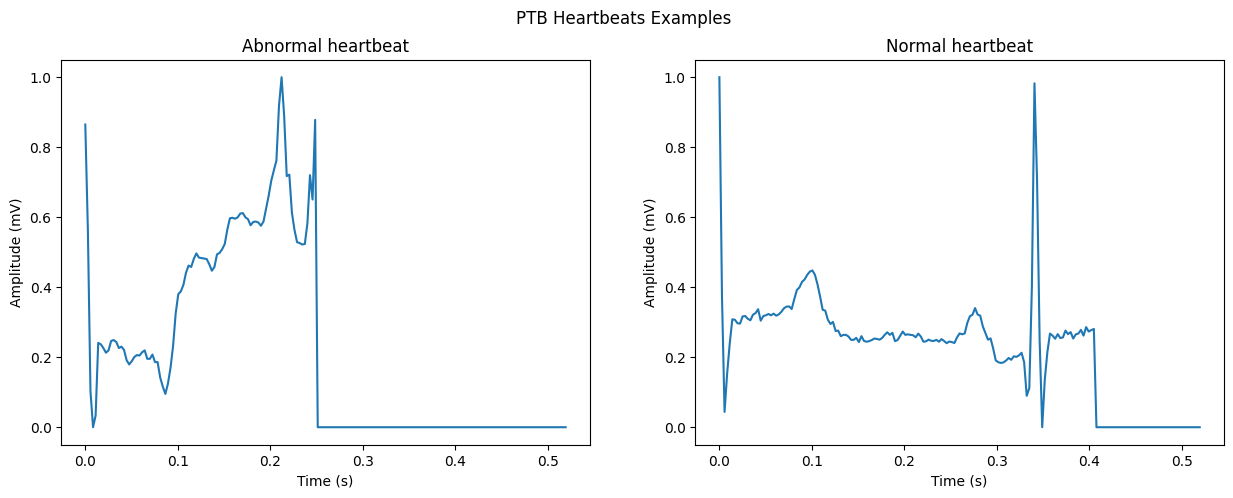

In [12]:
values = shuffled_ptbdb['target'].unique()

rows = len(values) // 2 if len(values) % 2 == 0 else len(values) // 2 + 1
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
fig.suptitle('PTB Heartbeats Examples')

axes = axes.flatten()
for i, value in enumerate(values):
    sequence = shuffled_ptbdb[shuffled_ptbdb['target'] == value].iloc[0, :-1].values
    axes[i].set_title(f'{ptbdb_target_labels[value]} heartbeat')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude (mV)')
    axes[i].plot(np.linspace(0, len(sequence)/360, len(sequence)), sequence)

for j in range(len(values), len(axes)):
    fig.delaxes(axes[j])

plt.show()

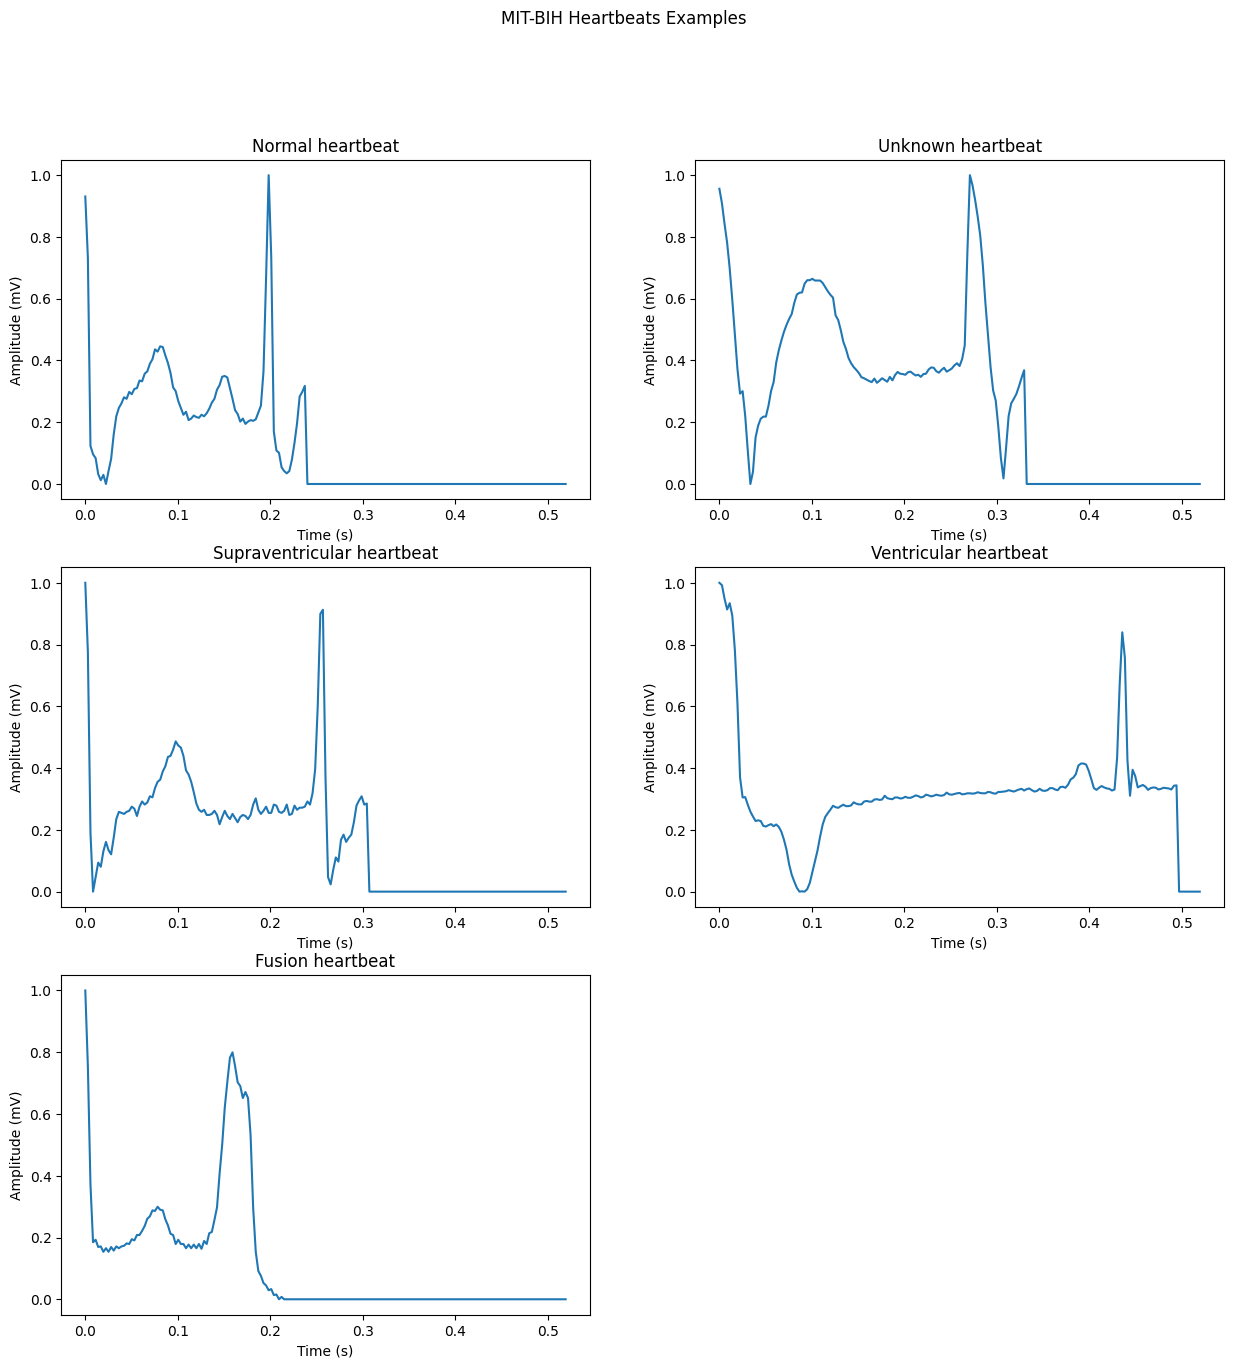

In [13]:
values = shuffled_mitbih['target'].unique()

rows = len(values) // 2 if len(values) % 2 == 0 else len(values) // 2 + 1
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
fig.suptitle('MIT-BIH Heartbeats Examples')

axes = axes.flatten()
for i, value in enumerate(values):
    sequence = shuffled_mitbih[shuffled_mitbih['target'] == value].iloc[0, :-1].values
    axes[i].set_title(f'{mitbih_target_labels[value]} heartbeat')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude (mV)')
    axes[i].plot(np.linspace(0, len(sequence)/360, len(sequence)), sequence)

for j in range(len(values), len(axes)):
    fig.delaxes(axes[j])
    
plt.show()

### Medie si Deviatie Standard (pentru fiecare unitate de timp)

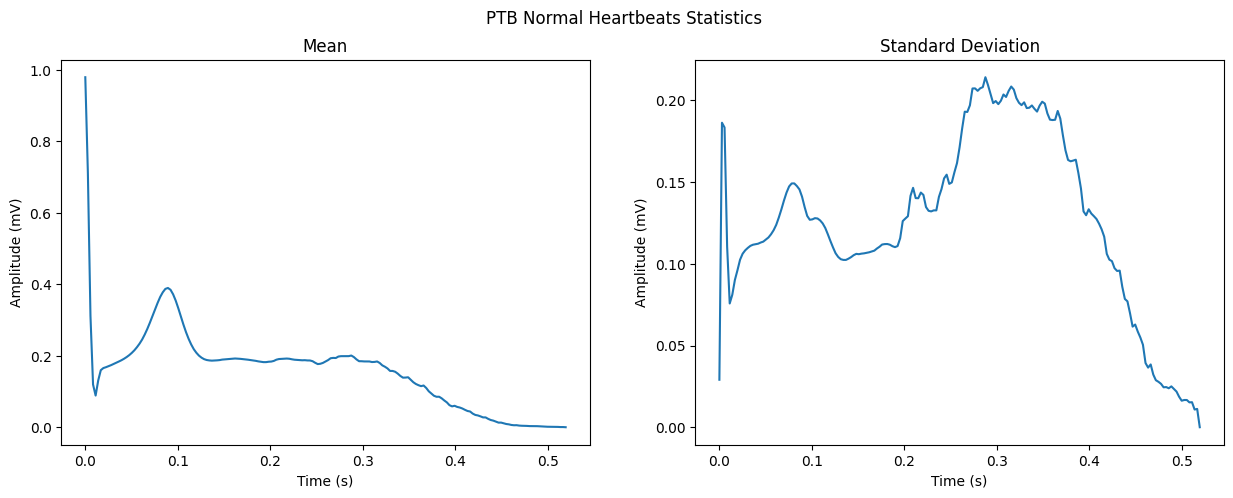

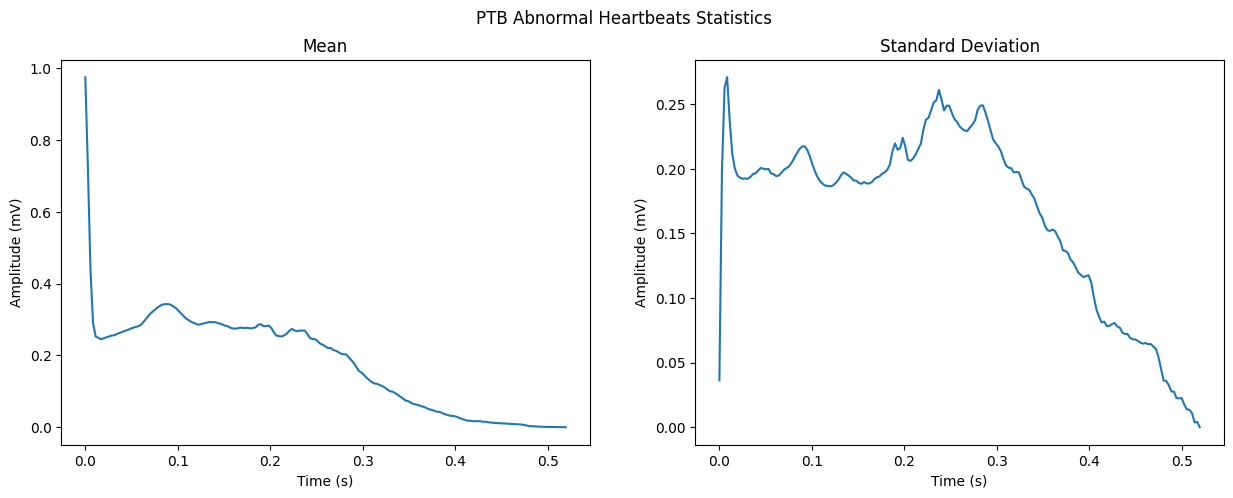

In [14]:
for value in ptbdb['target'].unique():
    means = [ptbdb[ptbdb['target'] == value][col].mean() for col in ptbdb.columns[:-1]]
    stds = [ptbdb[ptbdb['target'] == value][col].std() for col in ptbdb.columns[:-1]]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'PTB {ptbdb_target_labels[value]} Heartbeats Statistics')

    axes[0].set_title('Mean')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude (mV)')
    axes[0].plot(np.linspace(0, len(means)/360, len(means)), means)

    axes[1].set_title('Standard Deviation')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude (mV)')
    axes[1].plot(np.linspace(0, len(stds)/360, len(stds)), stds)

    plt.show()

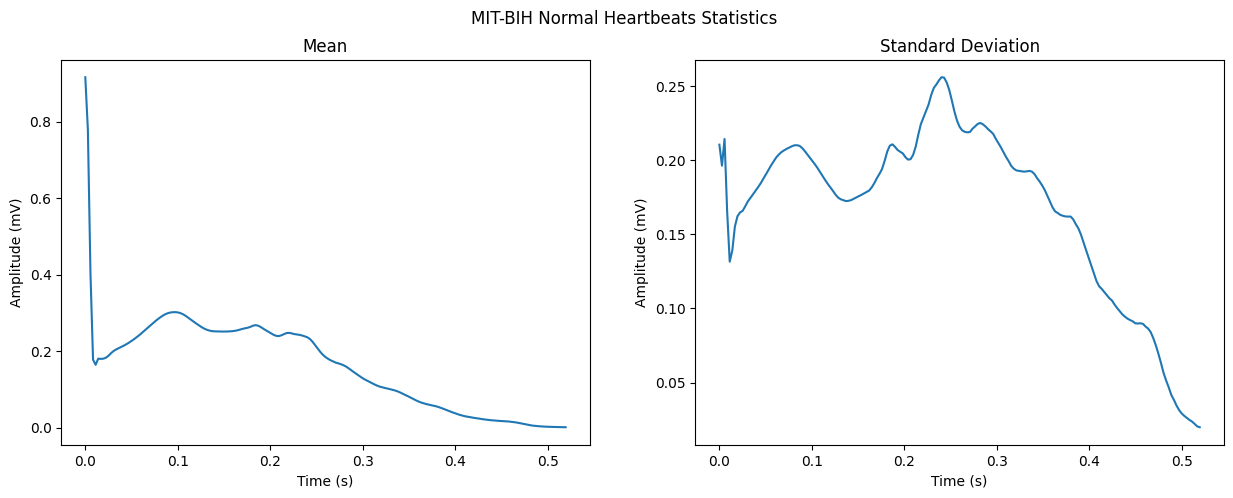

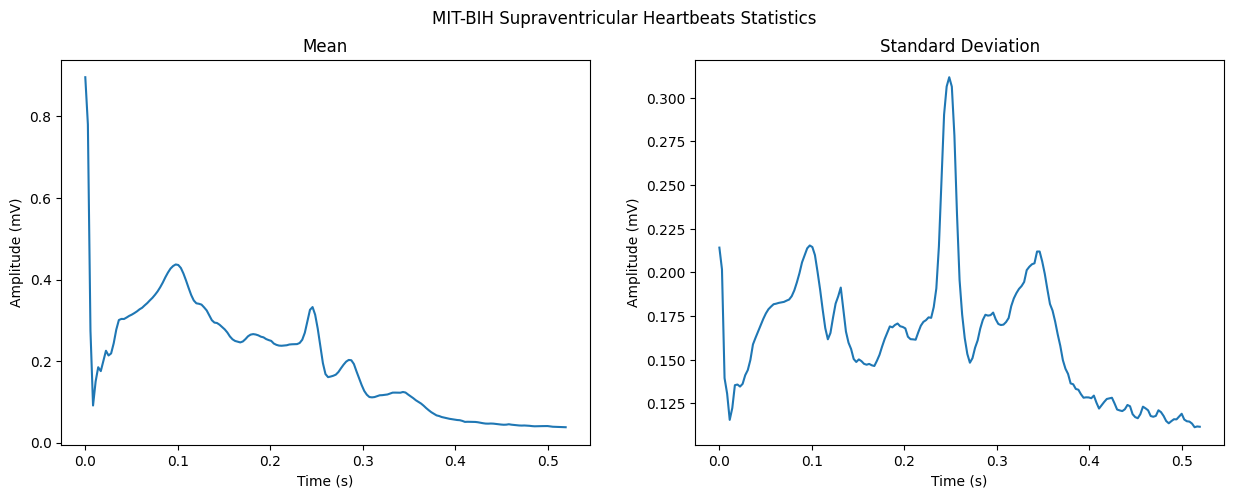

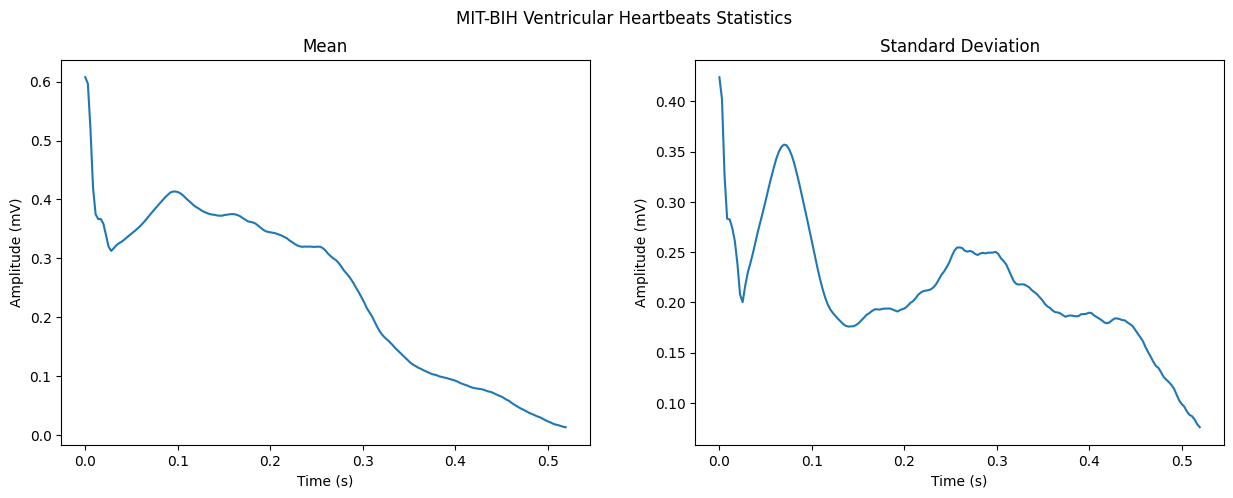

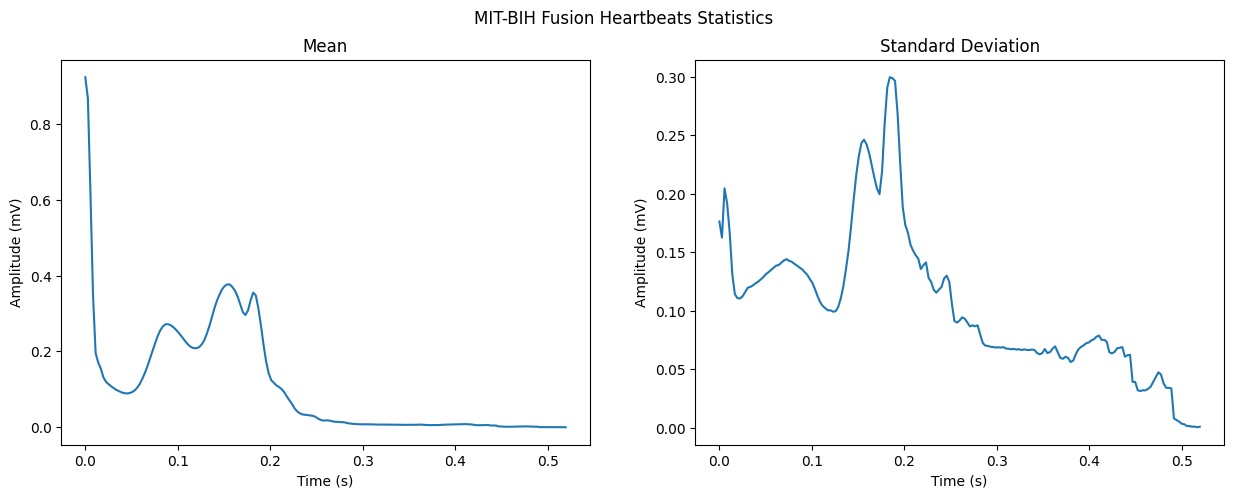

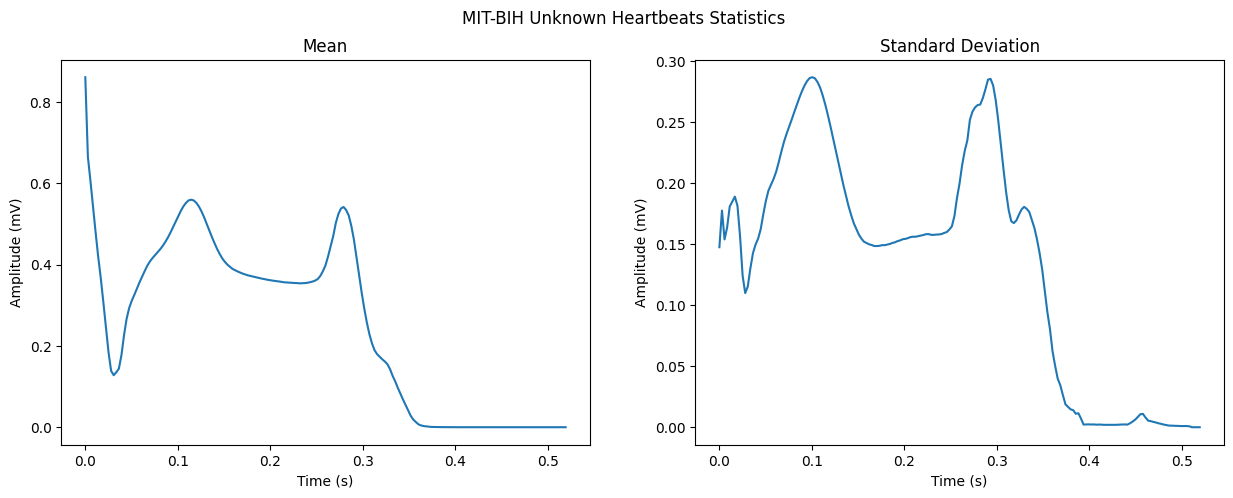

In [15]:
for value in mitbih['target'].unique():
    means = [mitbih[mitbih['target'] == value][col].mean() for col in mitbih.columns[:-1]]
    stds = [mitbih[mitbih['target'] == value][col].std() for col in mitbih.columns[:-1]]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'MIT-BIH {mitbih_target_labels[value]} Heartbeats Statistics')

    axes[0].set_title('Mean')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude (mV)')
    axes[0].plot(np.linspace(0, len(means)/360, len(means)), means)

    axes[1].set_title('Standard Deviation')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude (mV)')
    axes[1].plot(np.linspace(0, len(stds)/360, len(stds)), stds)

    plt.show()

# 3.2 Utilizarea modelelor RN

## MLPClassifier

### Impartirea setului de date in date de test si train

In [16]:
patients_x_train, patients_x_test, patients_y_train, patients_y_test = train_test_split(scaled_patients.drop(columns=['Diagnostic']), scaled_patients['Diagnostic'], test_size=0.2)
ptbdb_x_train, ptbdb_x_test, ptbdb_y_train, ptbdb_y_test = train_test_split(ptbdb.drop(columns=['target']), ptbdb['target'], test_size=0.2)
mitbih_x_train, mitbih_x_test, mitbih_y_train, mitbih_y_test = train_test_split(mitbih.drop(columns=['target']), mitbih['target'], test_size=0.2)

hidden_layer_sizes_list = \
    [
        (100,),
        (200,),
        (100, 50),
        (200, 100),
        (100, 50, 25),
        (150, 100, 50),
    ]

data = \
    [
        ('Patients', patients_x_train, patients_x_test, patients_y_train, patients_y_test),
        ('PTB',ptbdb_x_train, ptbdb_x_test, ptbdb_y_train, ptbdb_y_test),
        ('MitBi', mitbih_x_train, mitbih_x_test, mitbih_y_train, mitbih_y_test)
    ]

combos = list(product(data, hidden_layer_sizes_list))

### Antrenarea modelului si evaluarea performatelor

In [17]:
def compute_stats(hidden_layer_sizes, model, x_test, y_test):
    y_predicted = model.predict(x_test)
    return \
        {
            'hidden_layer_sizes': hidden_layer_sizes,
            'iterations': model.n_iter_,
            'loss_curve': model.loss_curve_,
            'metrics':
            {
                'accuracy': accuracy_score(y_test, y_predicted),
                'precision': precision_score(y_test, y_predicted, average='weighted'),
                'recall': recall_score(y_test, y_predicted, average='weighted'),
                'f1': f1_score(y_test, y_predicted, average='weighted')
            },
            'confusion_matrix': confusion_matrix(y_test, y_predicted),
        }

In [ ]:
stats = \
    {
        'MLPClassifier Adam Adaptive': {},
        'MLPClassifier SGD Adaptive Momentum=0.9': {}
    }

for combo in combos:
    clf = MLPClassifier(hidden_layer_sizes=combo[1], max_iter=5000, solver='adam', learning_rate='adaptive')
    clf.fit(combo[0][1], combo[0][3])

    if combo[0][0] not in stats['MLPClassifier Adam Adaptive']:
        stats['MLPClassifier Adam Adaptive'][combo[0][0]] = []
    stats['MLPClassifier Adam Adaptive'][combo[0][0]].append(compute_stats(combo[1], clf, combo[0][2], combo[0][4]))

    clf = MLPClassifier(hidden_layer_sizes=combo[1], max_iter=5000, solver='sgd', momentum=0.9, learning_rate='adaptive')
    clf.fit(combo[0][1], combo[0][3])

    if combo[0][0] not in stats['MLPClassifier SGD Adaptive Momentum=0.9']: 
        stats['MLPClassifier SGD Adaptive Momentum=0.9'][combo[0][0]] = []
    stats['MLPClassifier SGD Adaptive Momentum=0.9'][combo[0][0]].append(compute_stats(combo[1], clf, combo[0][2], combo[0][4]))

    print(f'({combo[0][0]}) MLPClassifier {combo[1]} done')

with open('mlp_stats.json', 'w') as f:
    stats2 = copy.deepcopy(stats)

    for key in stats2:
        for dataset in stats2[key]:
            for i in range(len(stats2[key][dataset])):
                stats2[key][dataset][i]['confusion_matrix'] = stats2[key][dataset][i]['confusion_matrix'].tolist()

    f.write(json.dumps(stats2, indent=4))

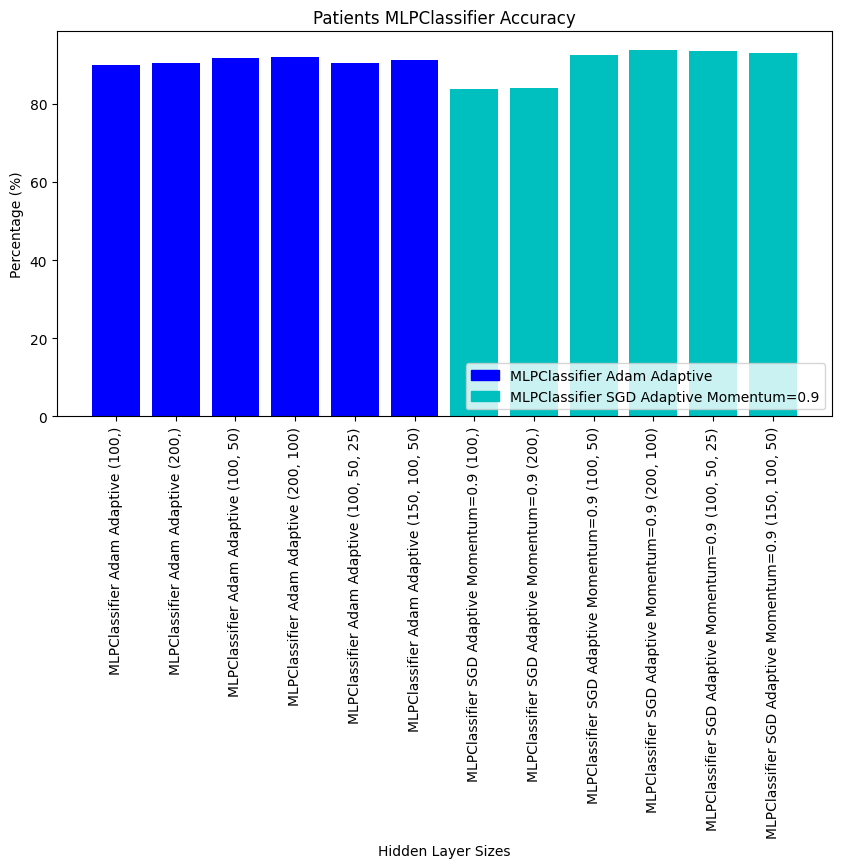

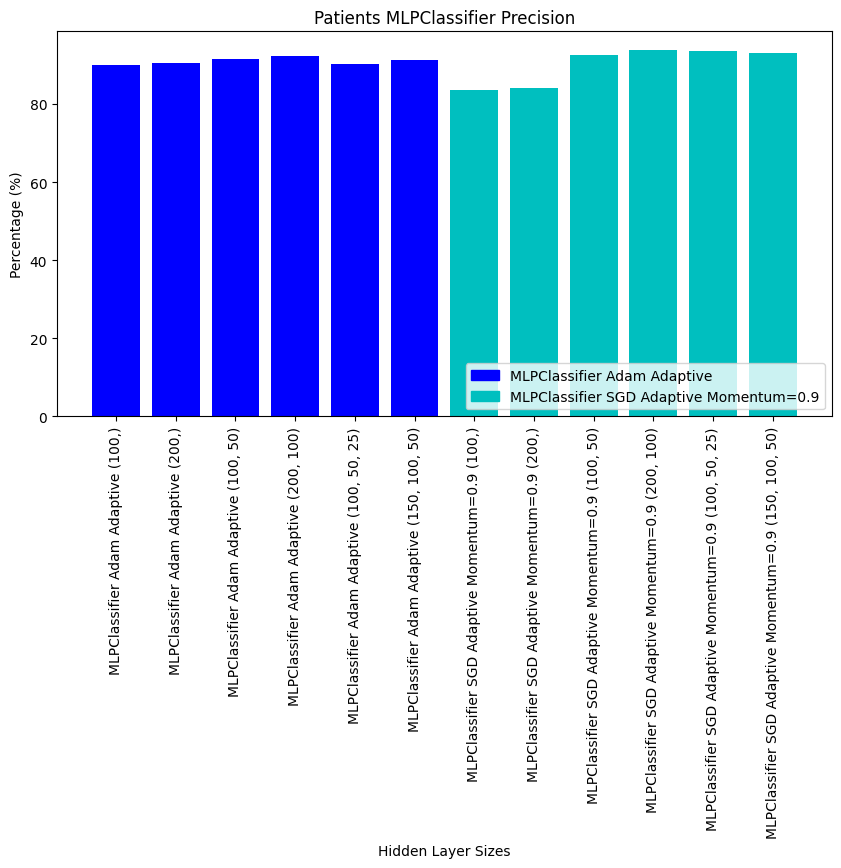

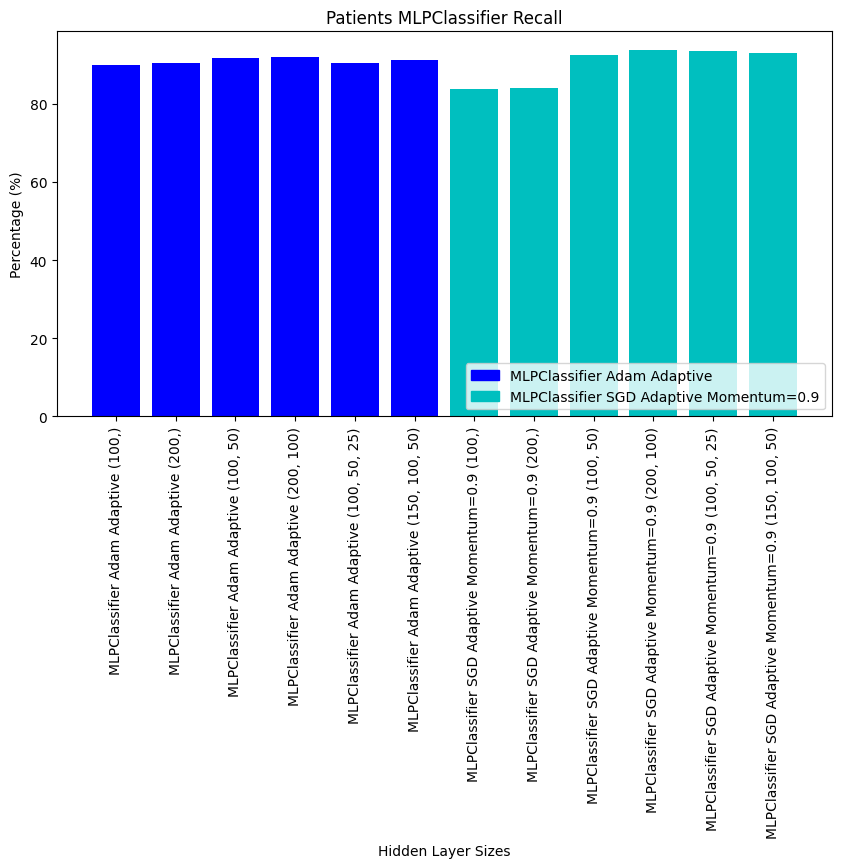

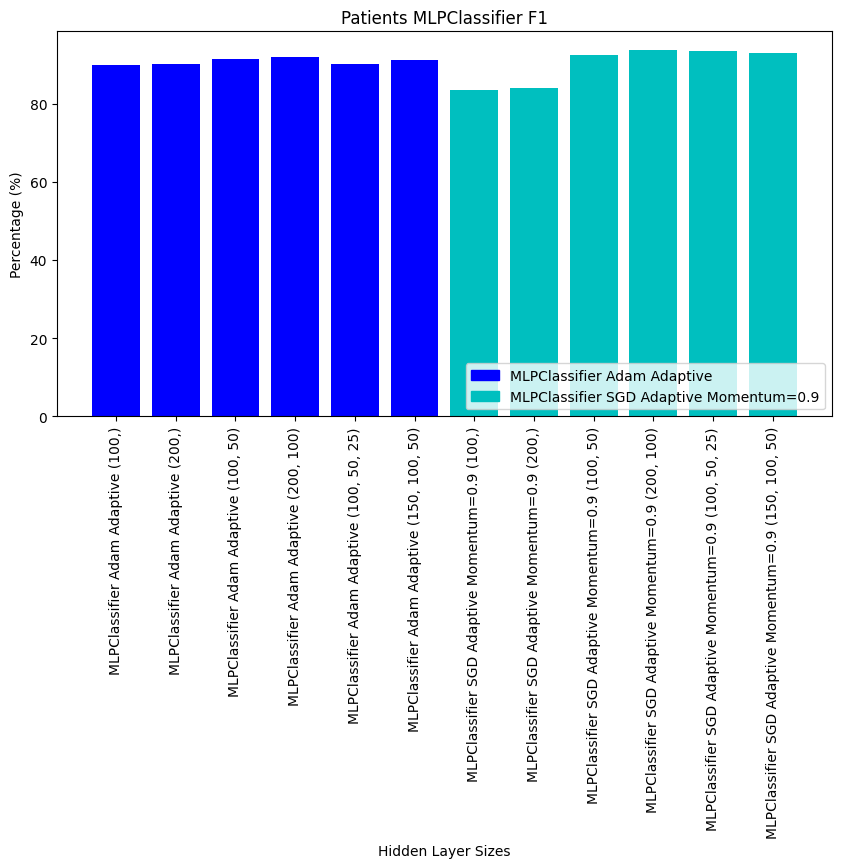

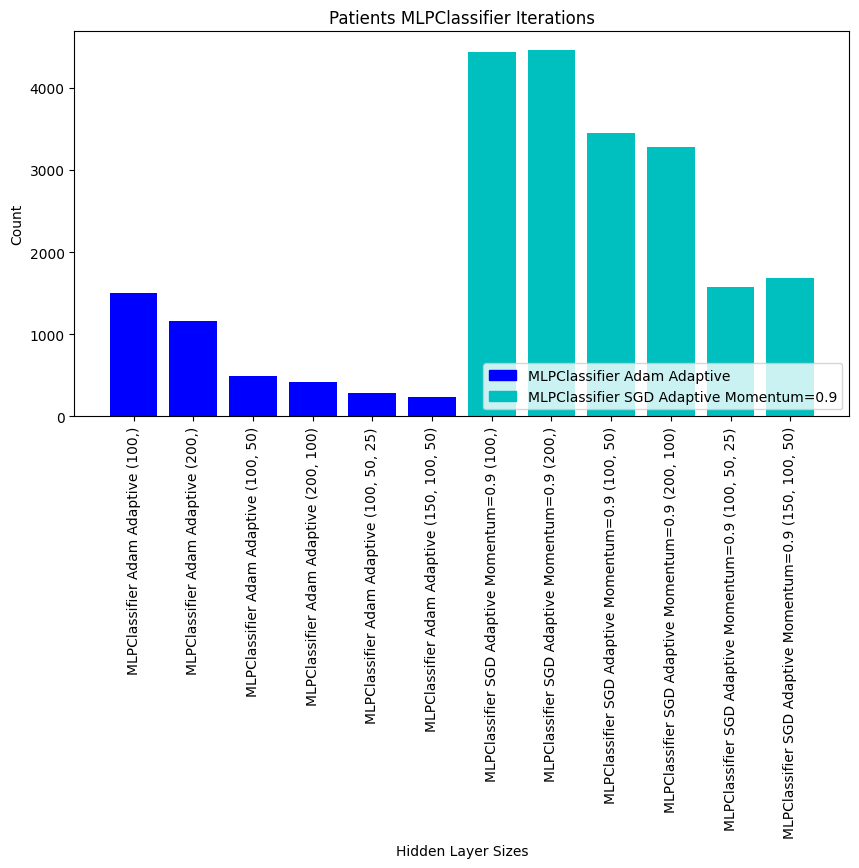

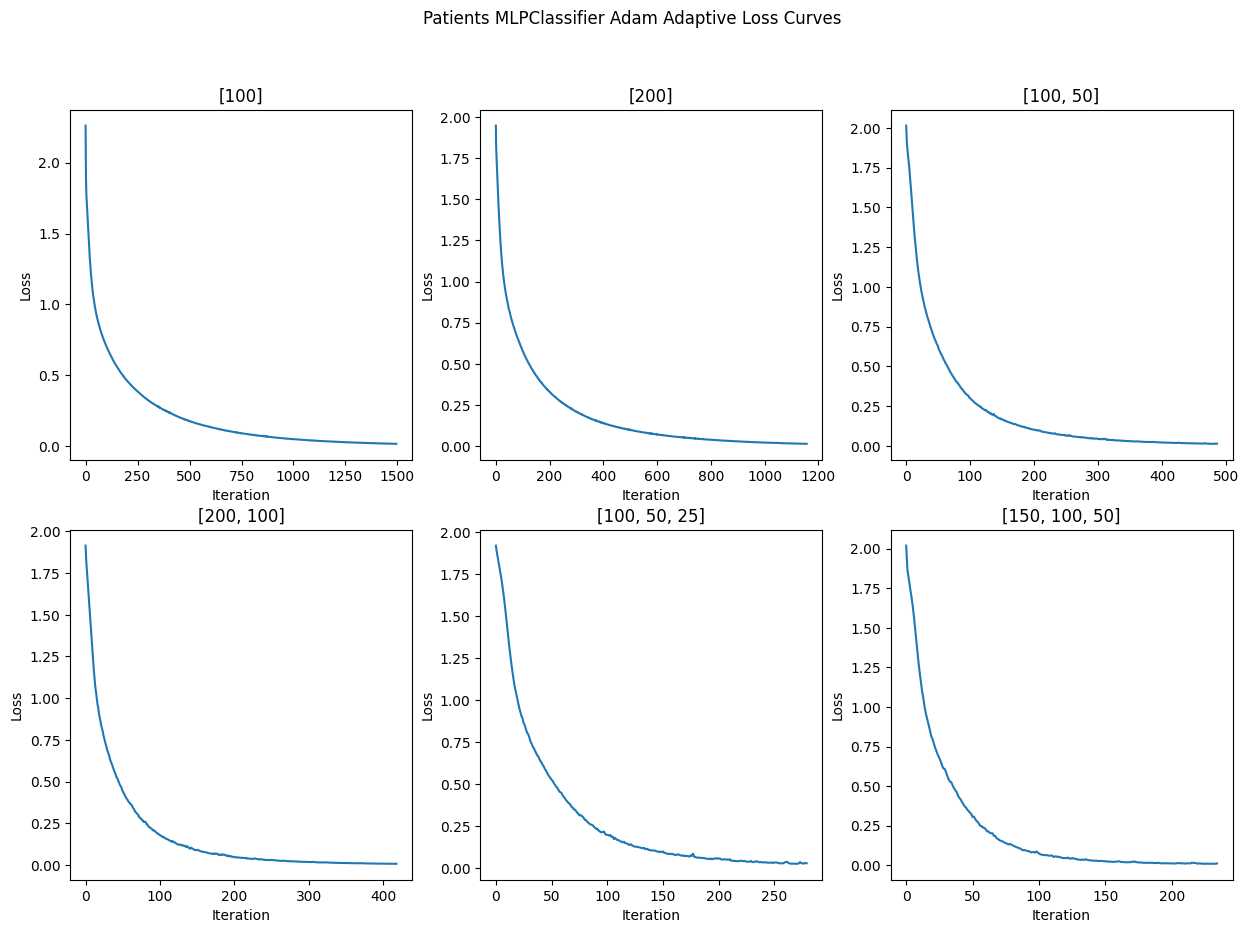

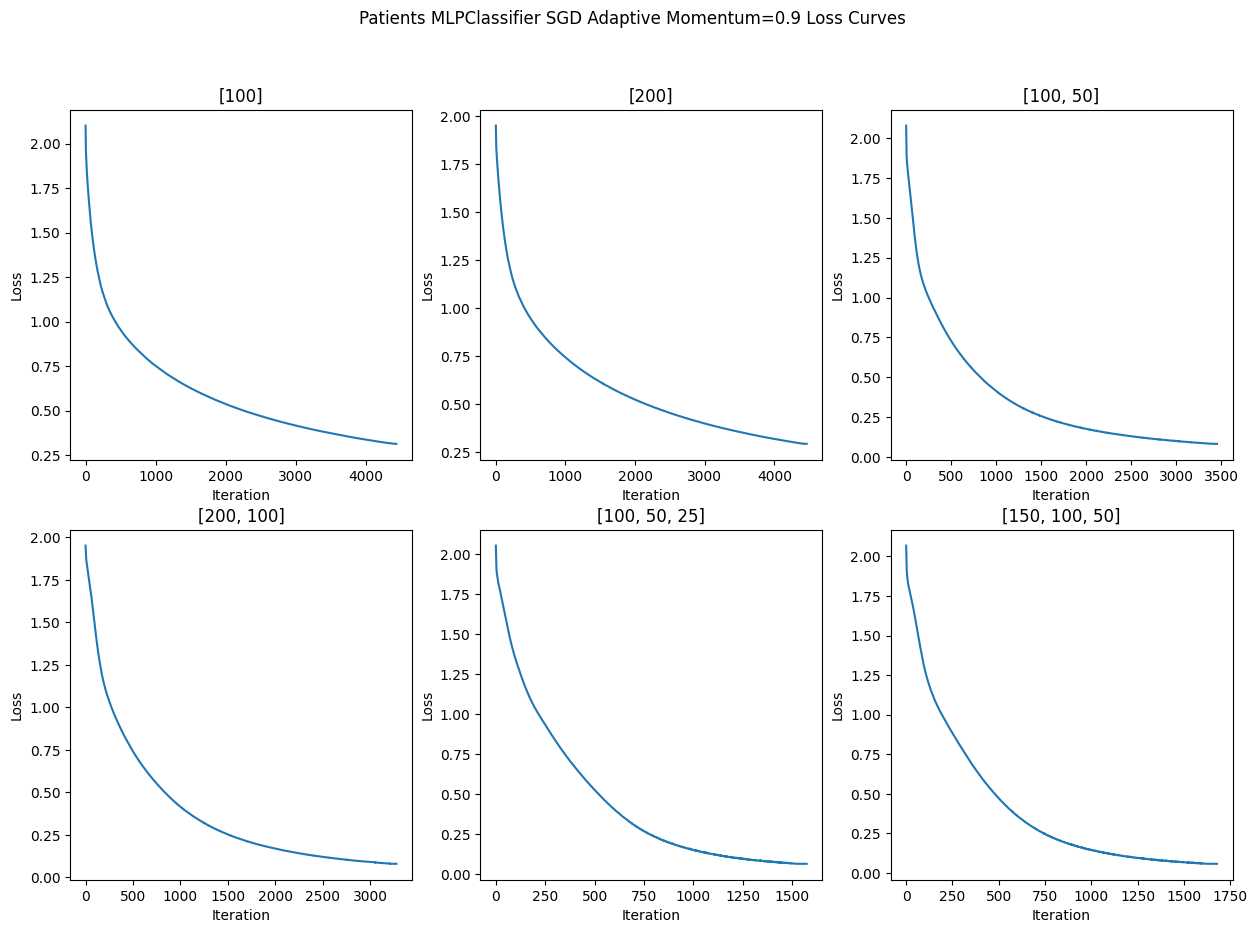

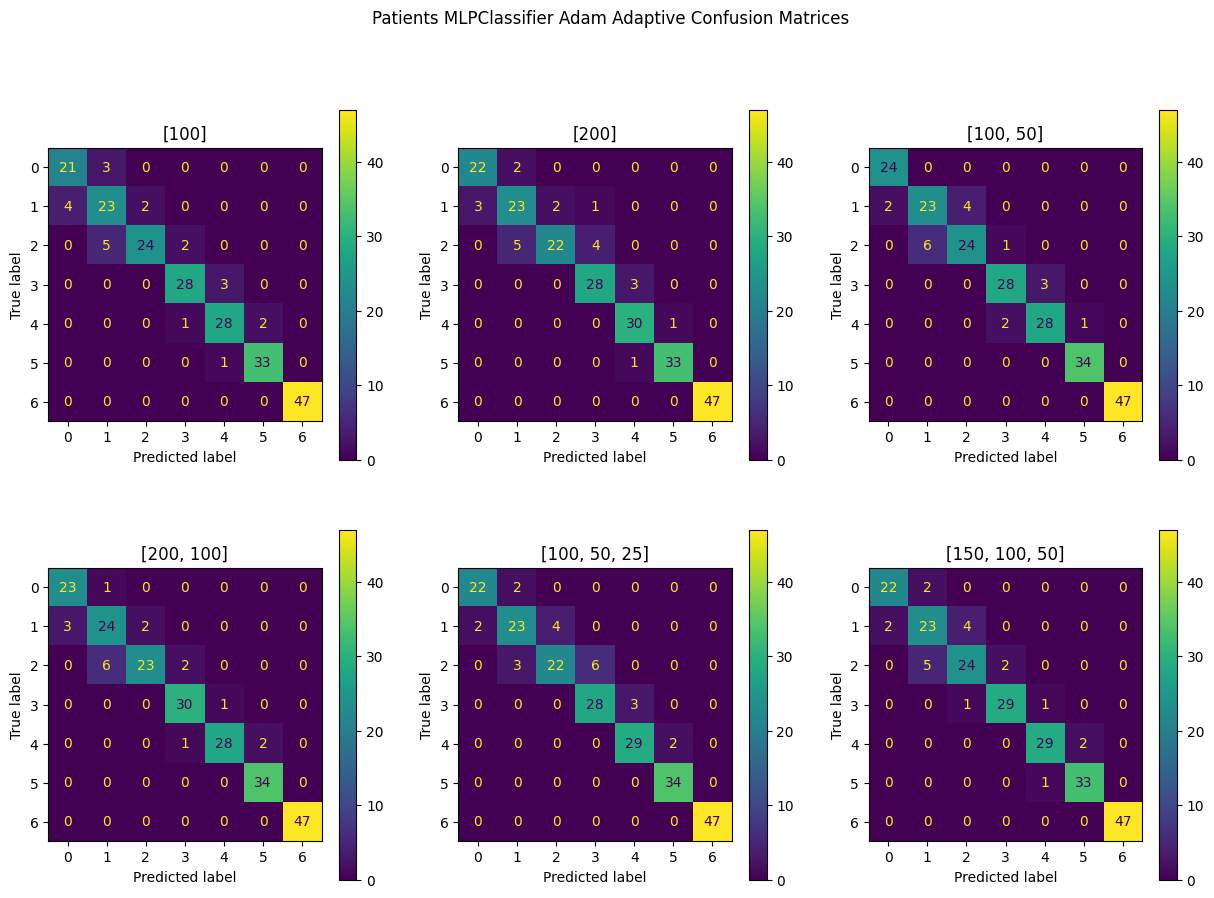

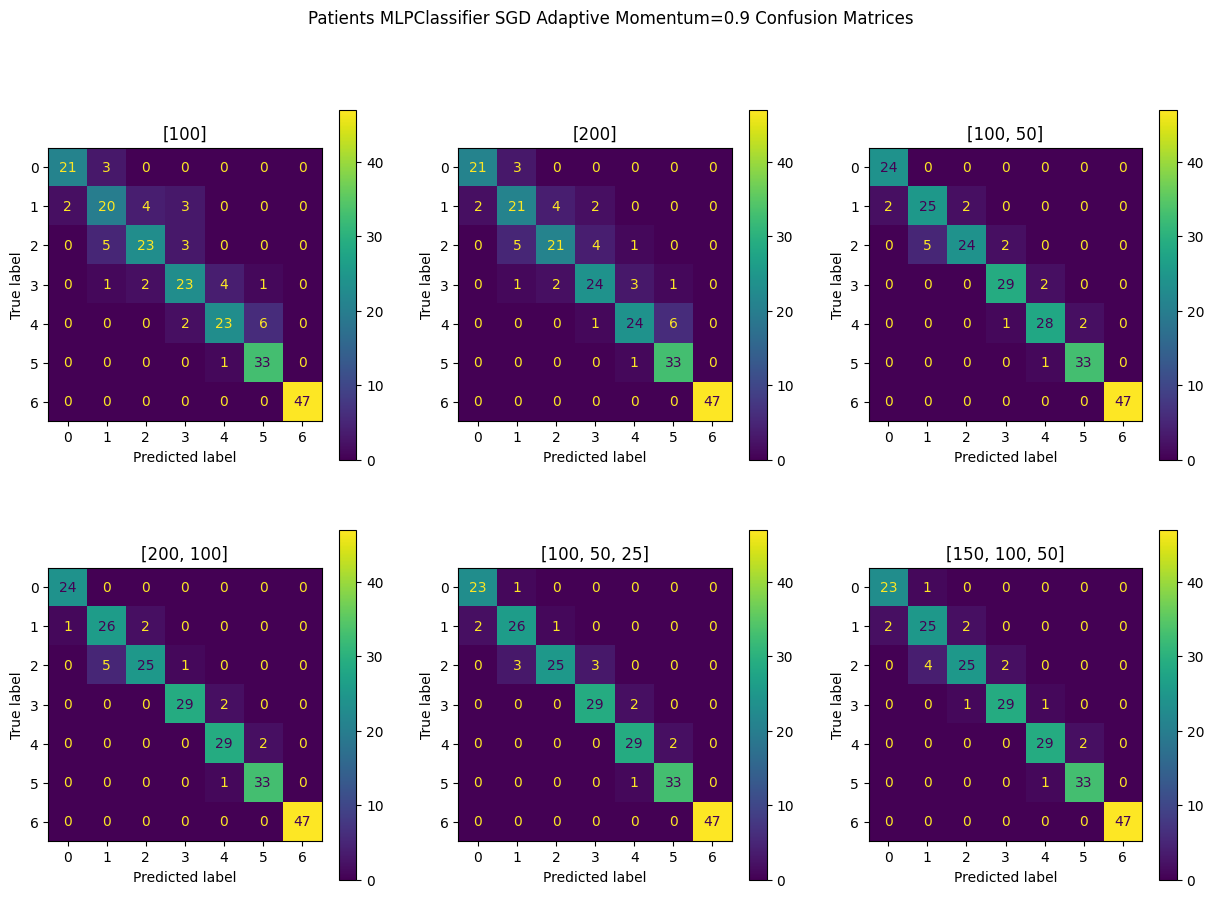

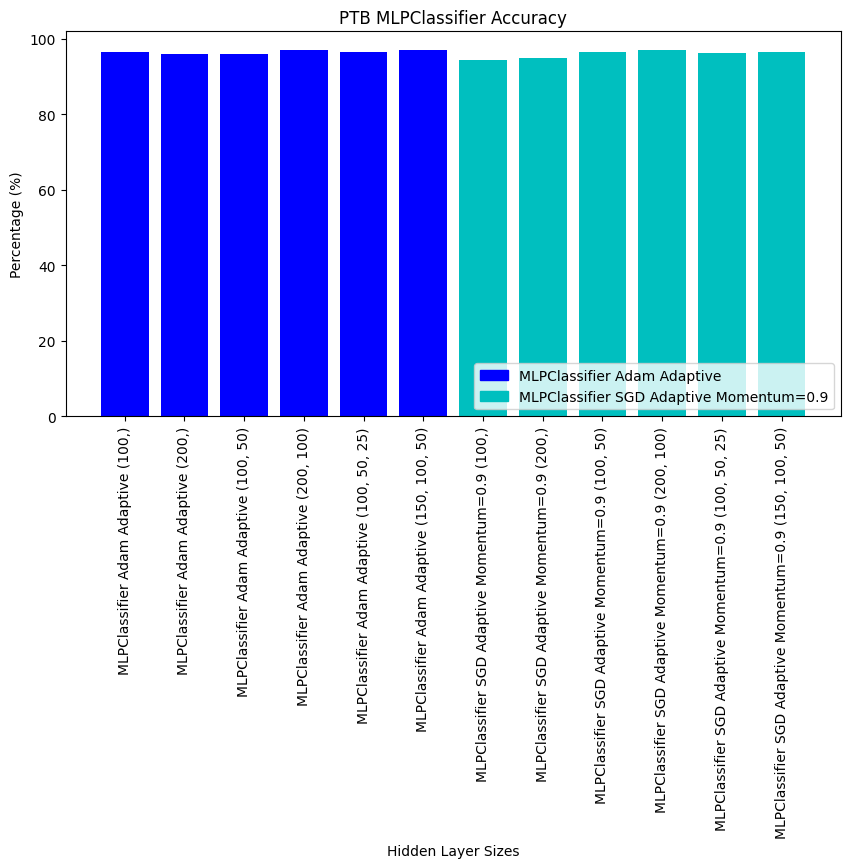

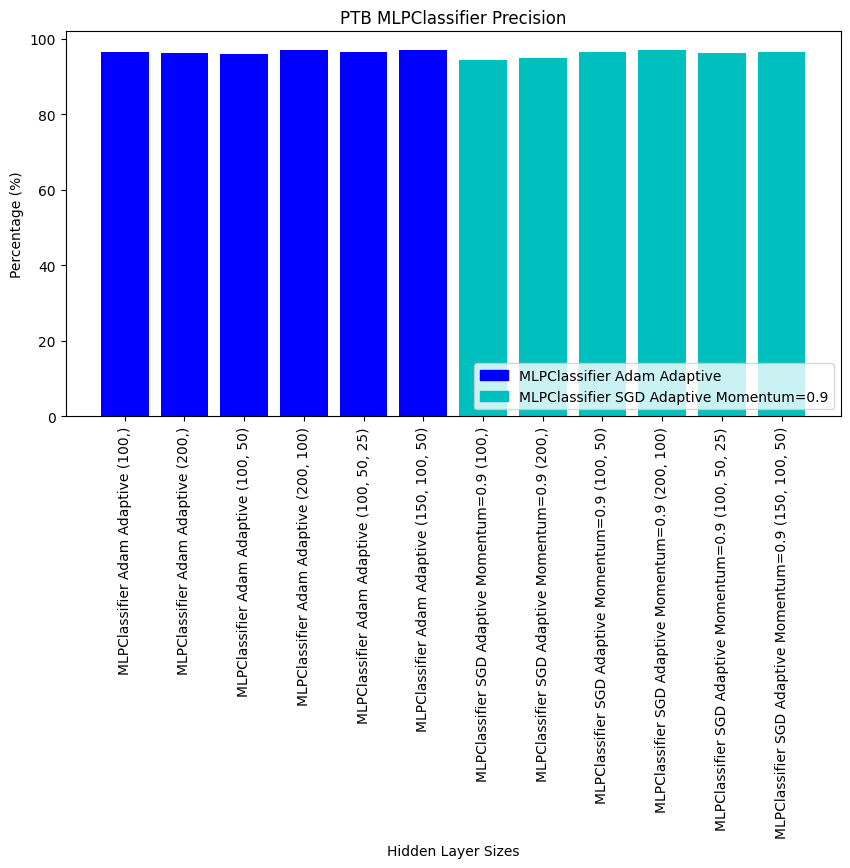

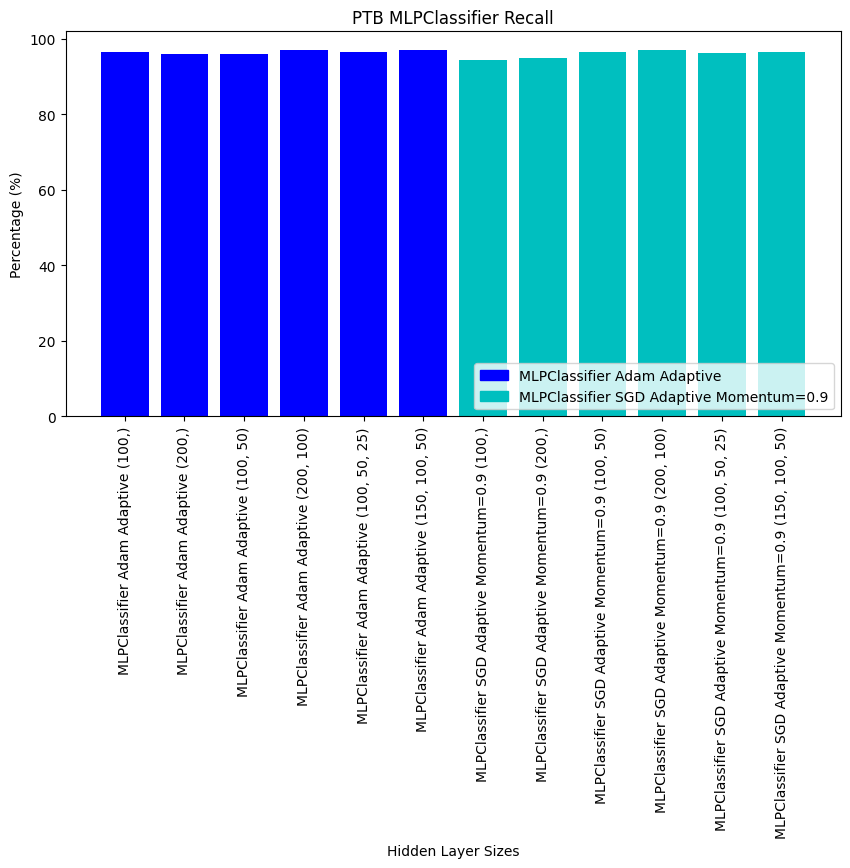

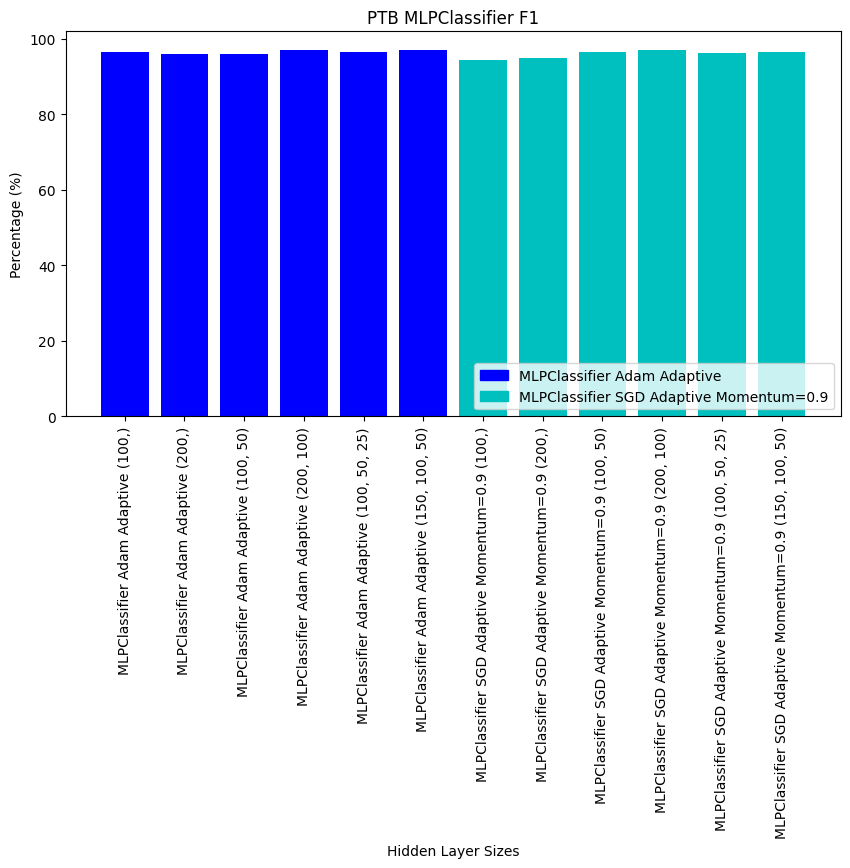

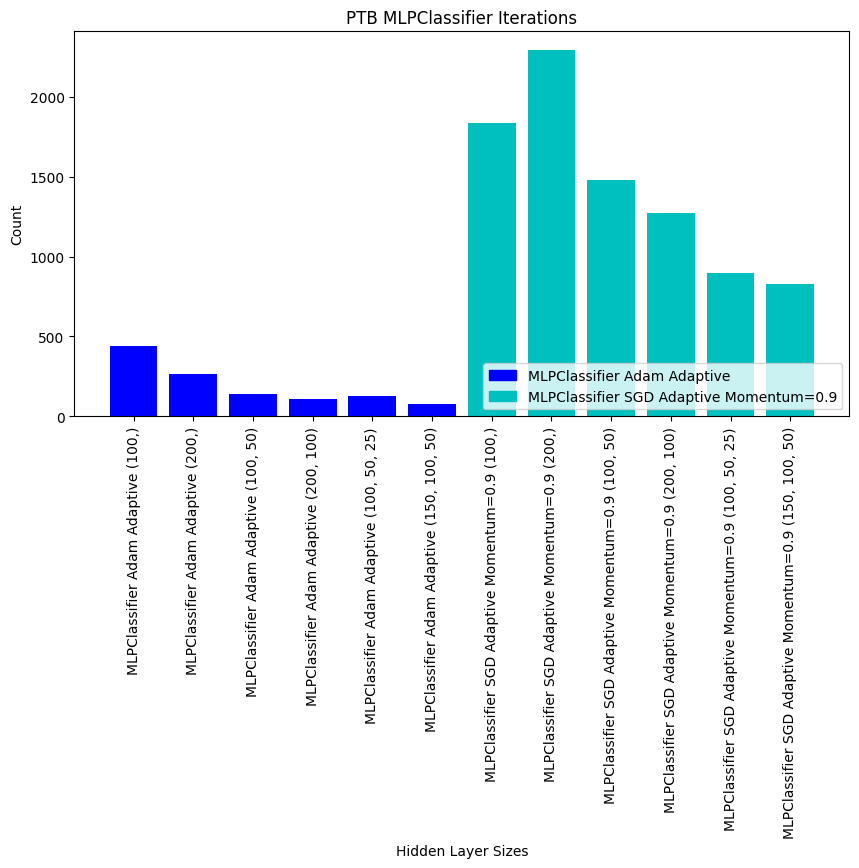

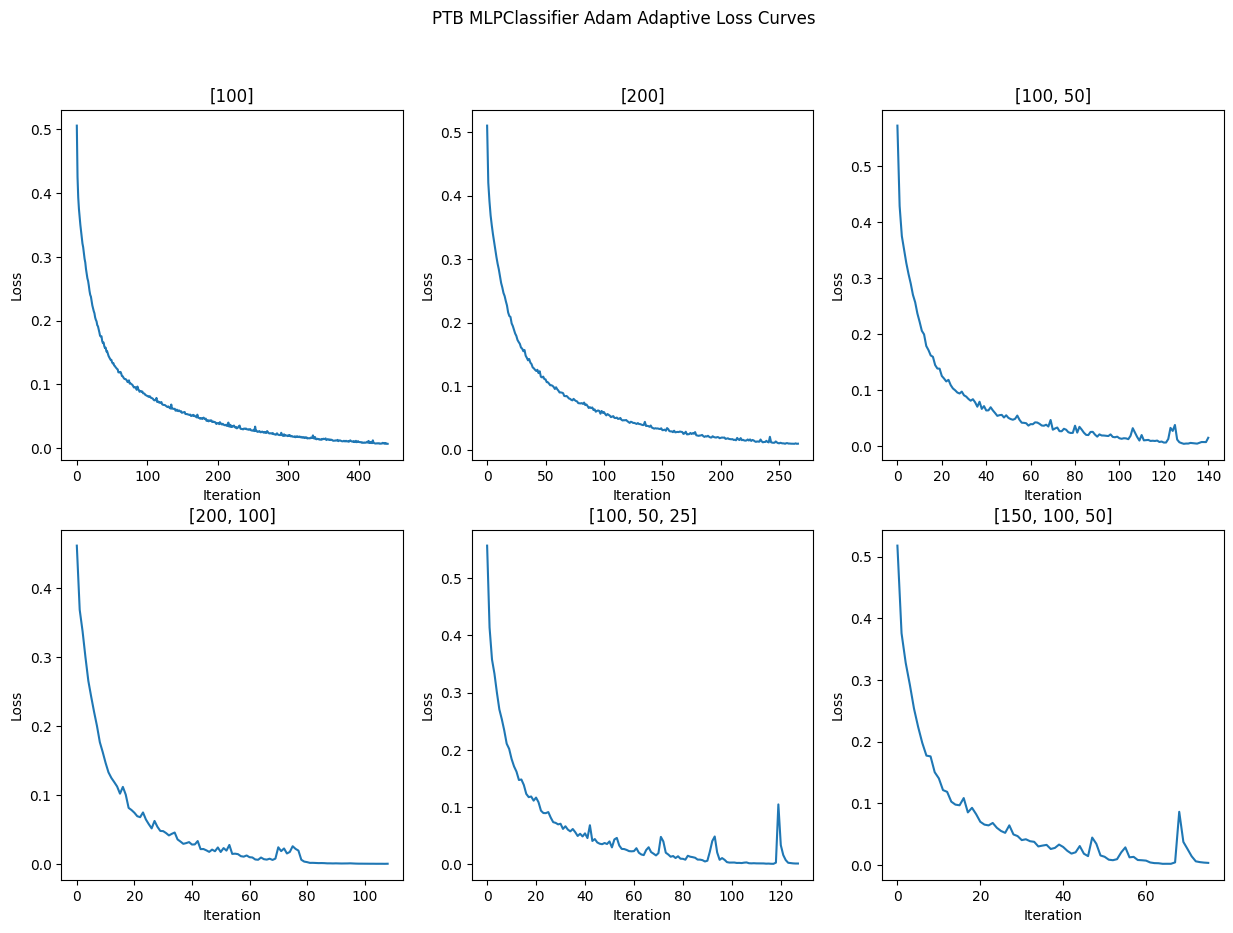

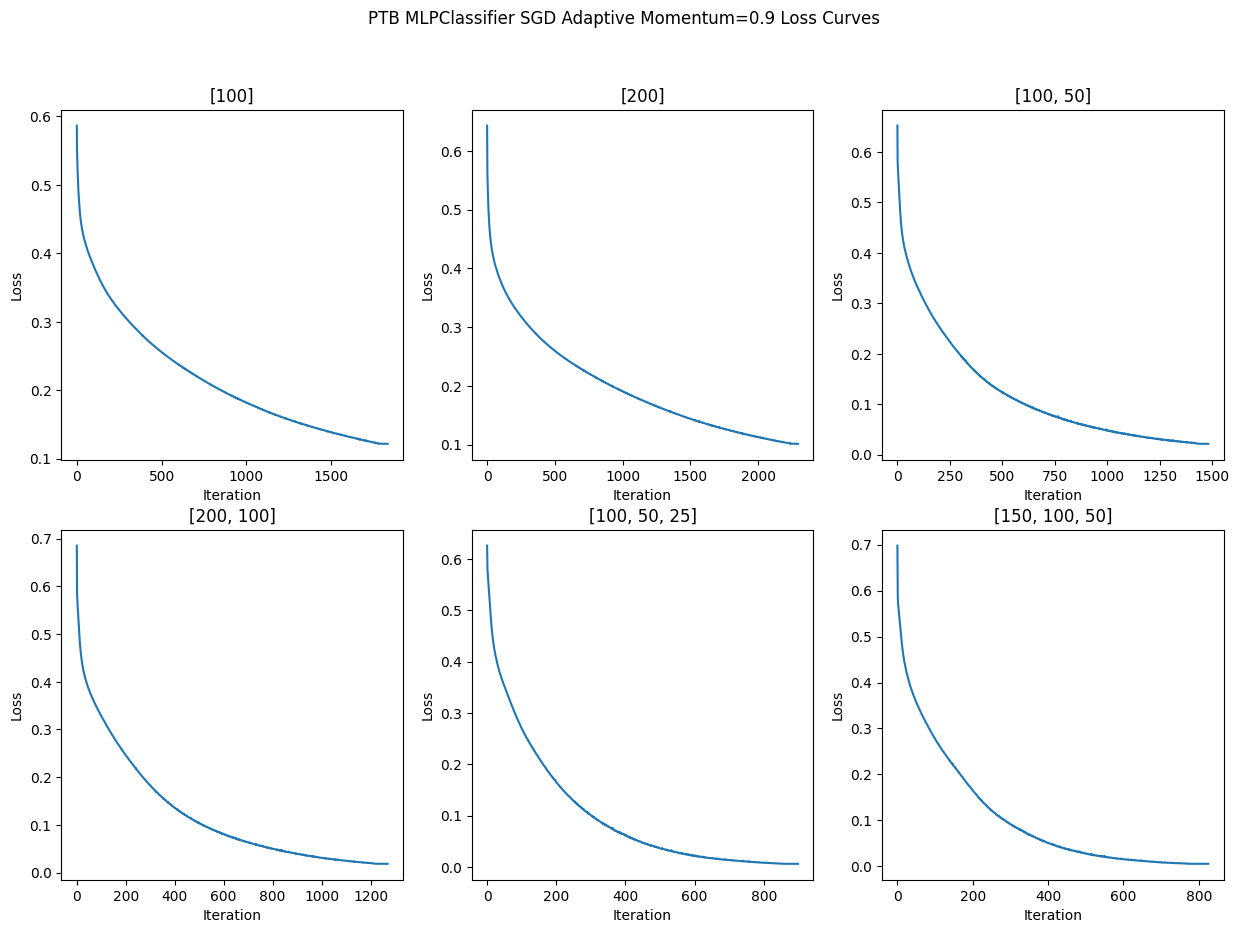

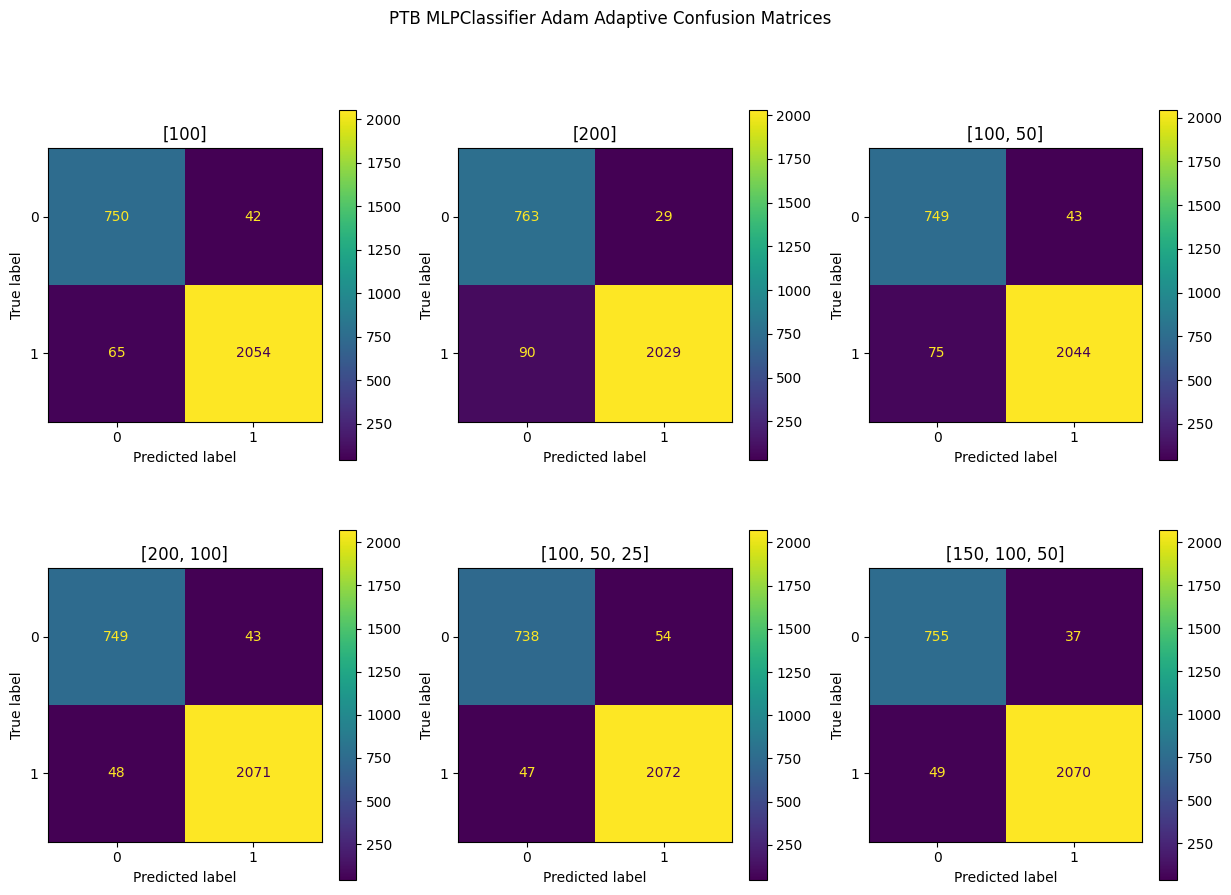

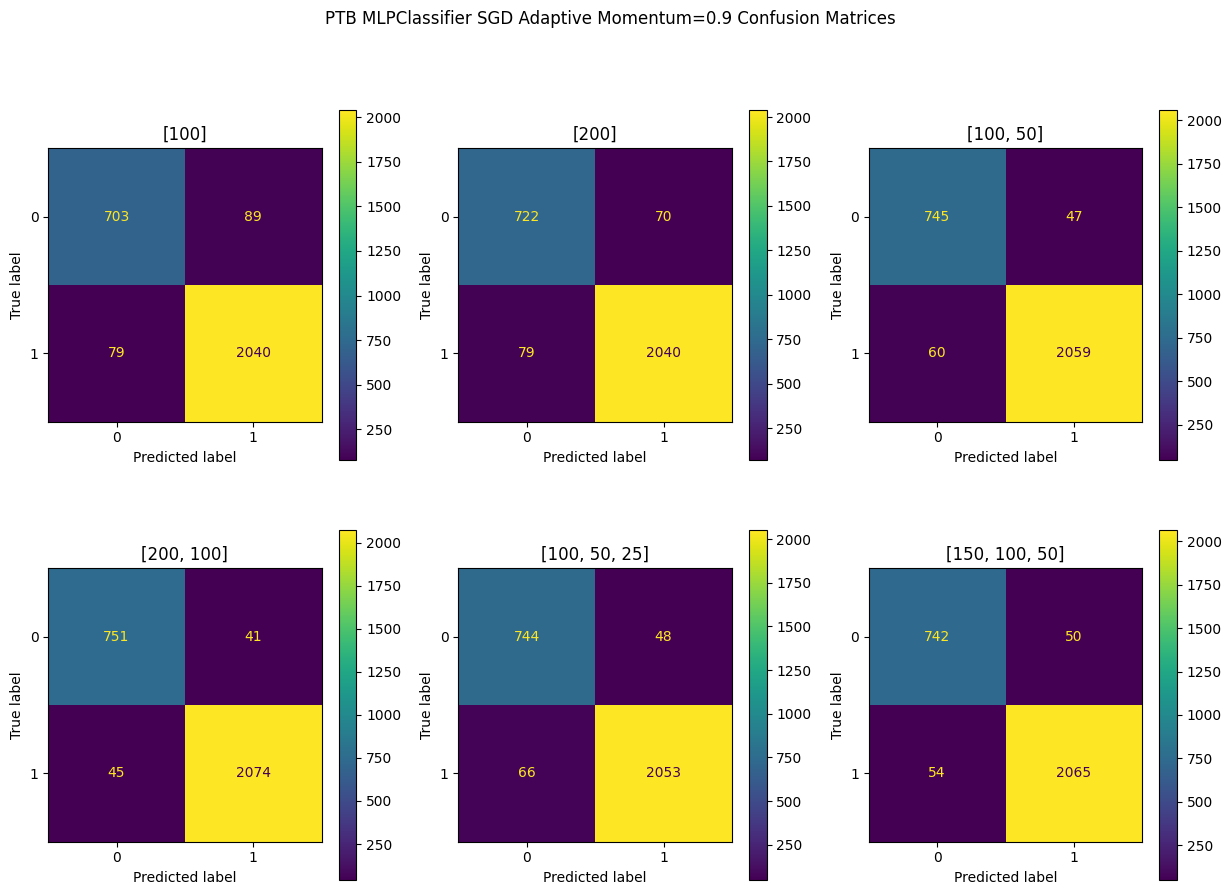

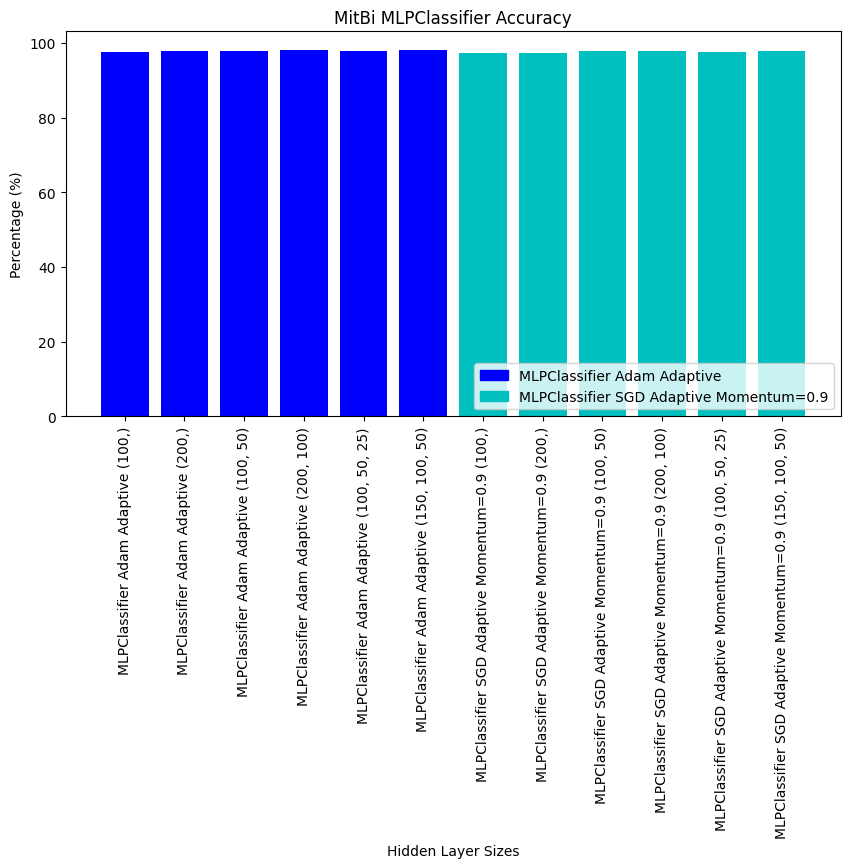

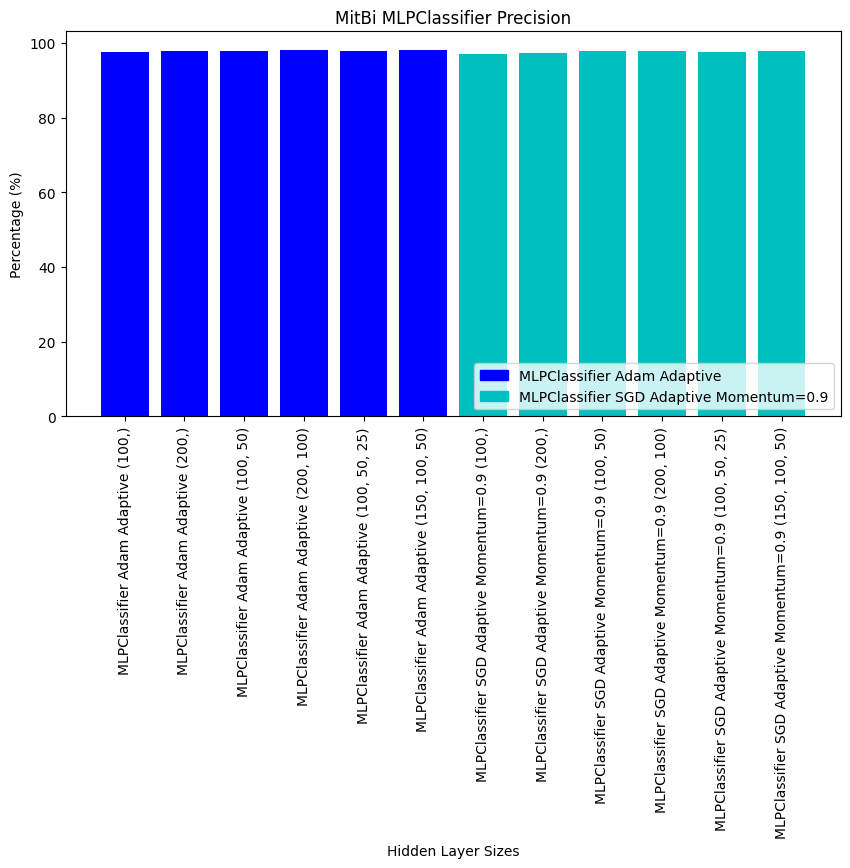

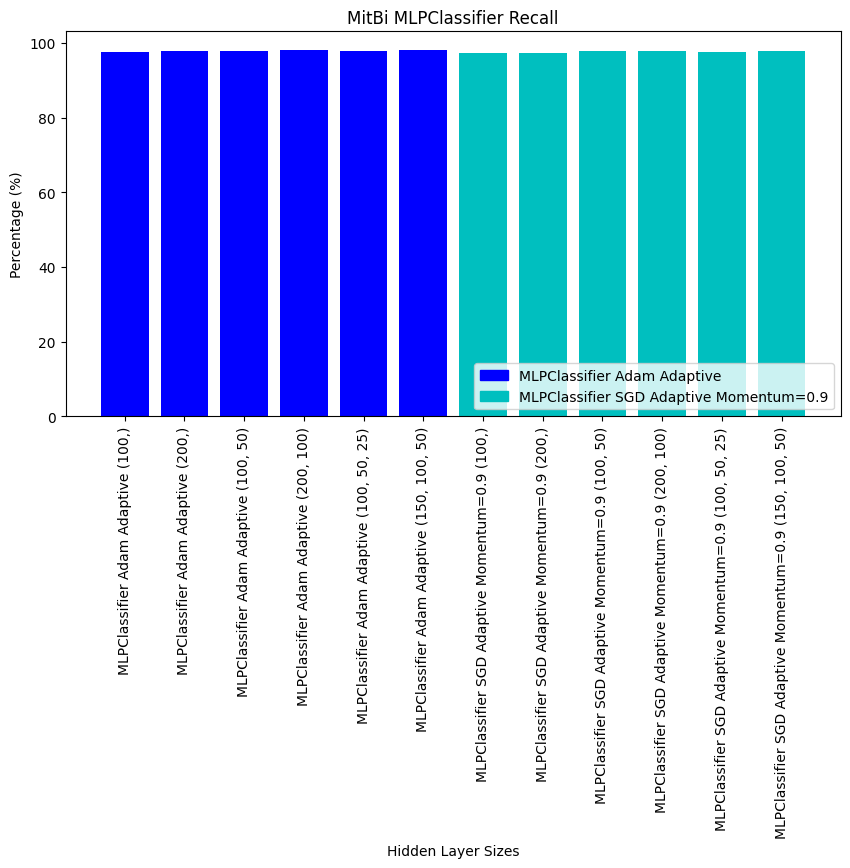

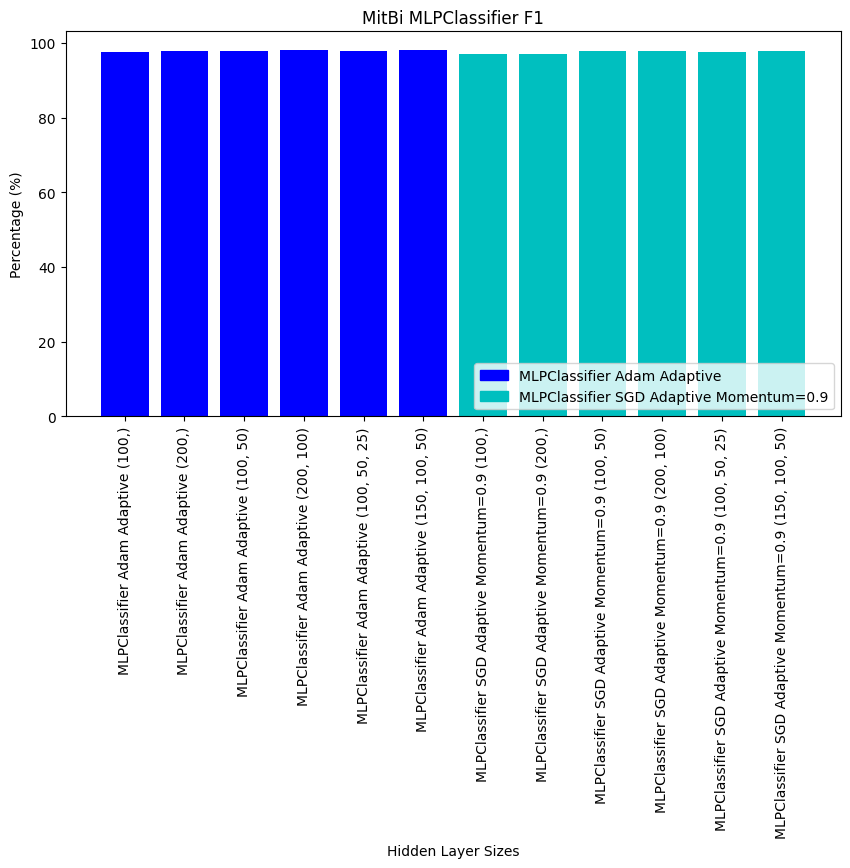

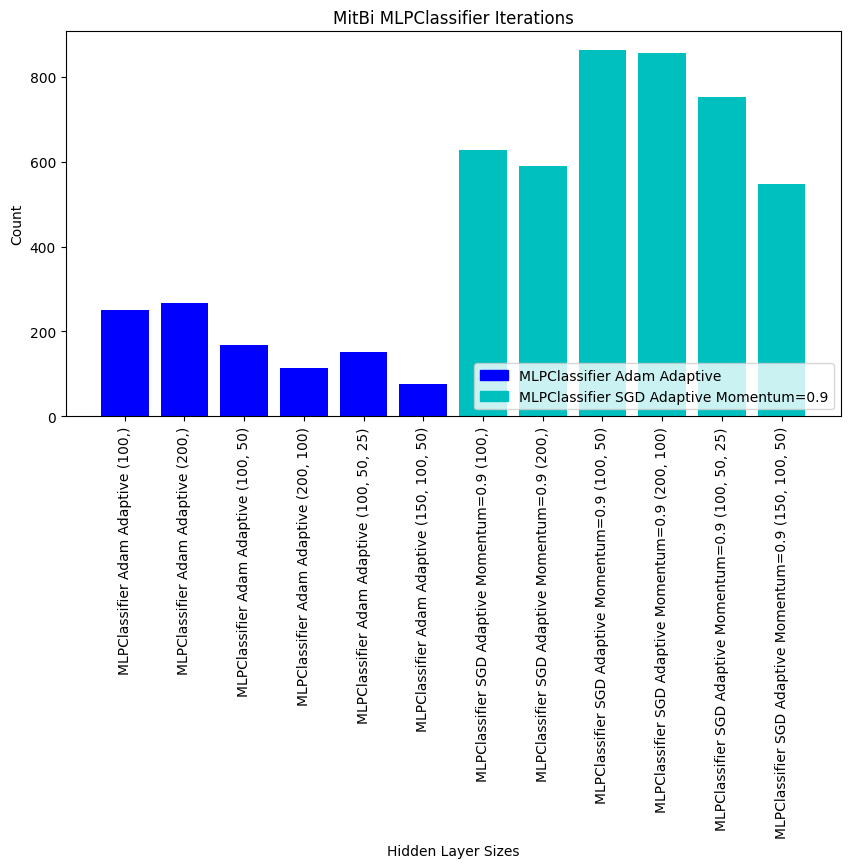

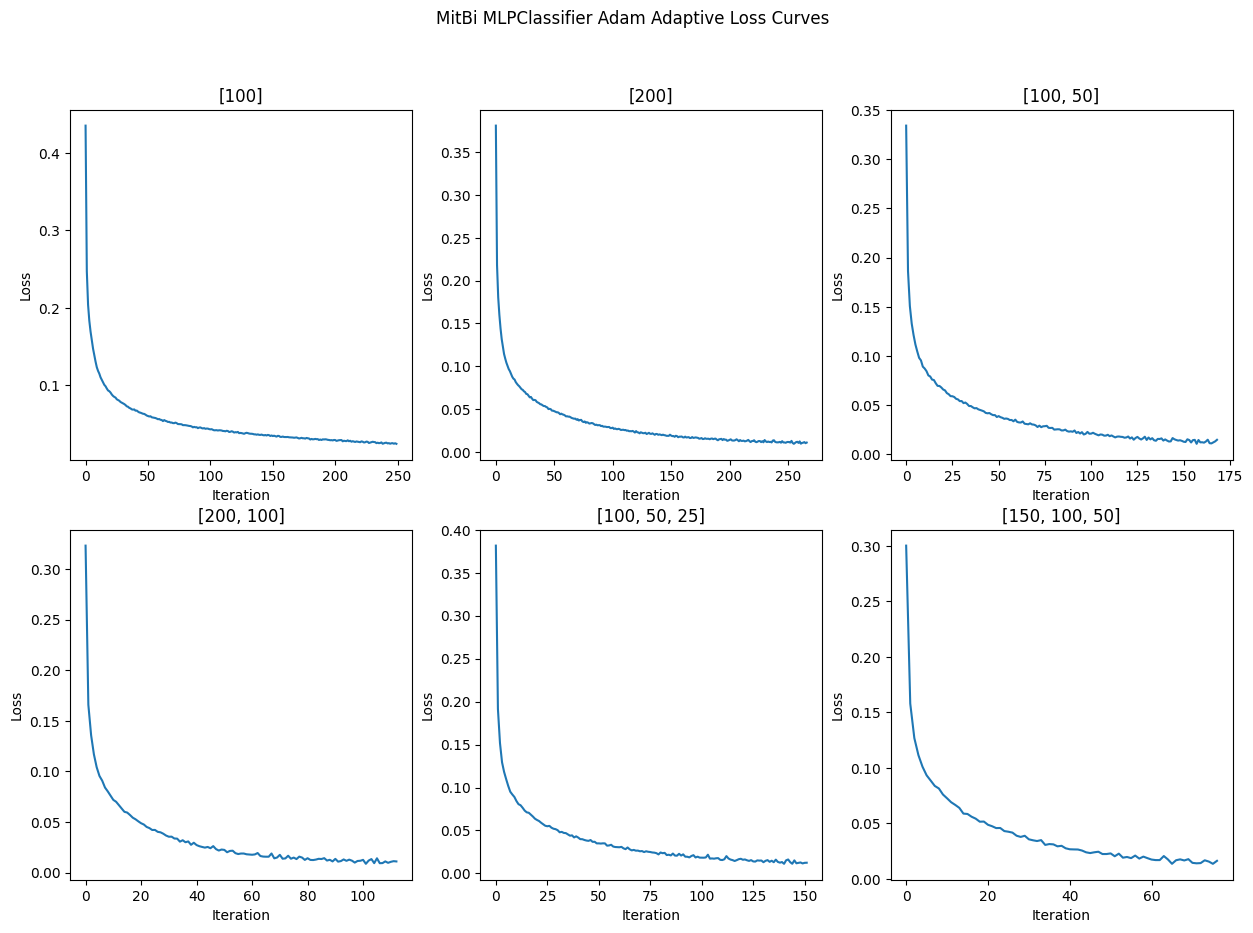

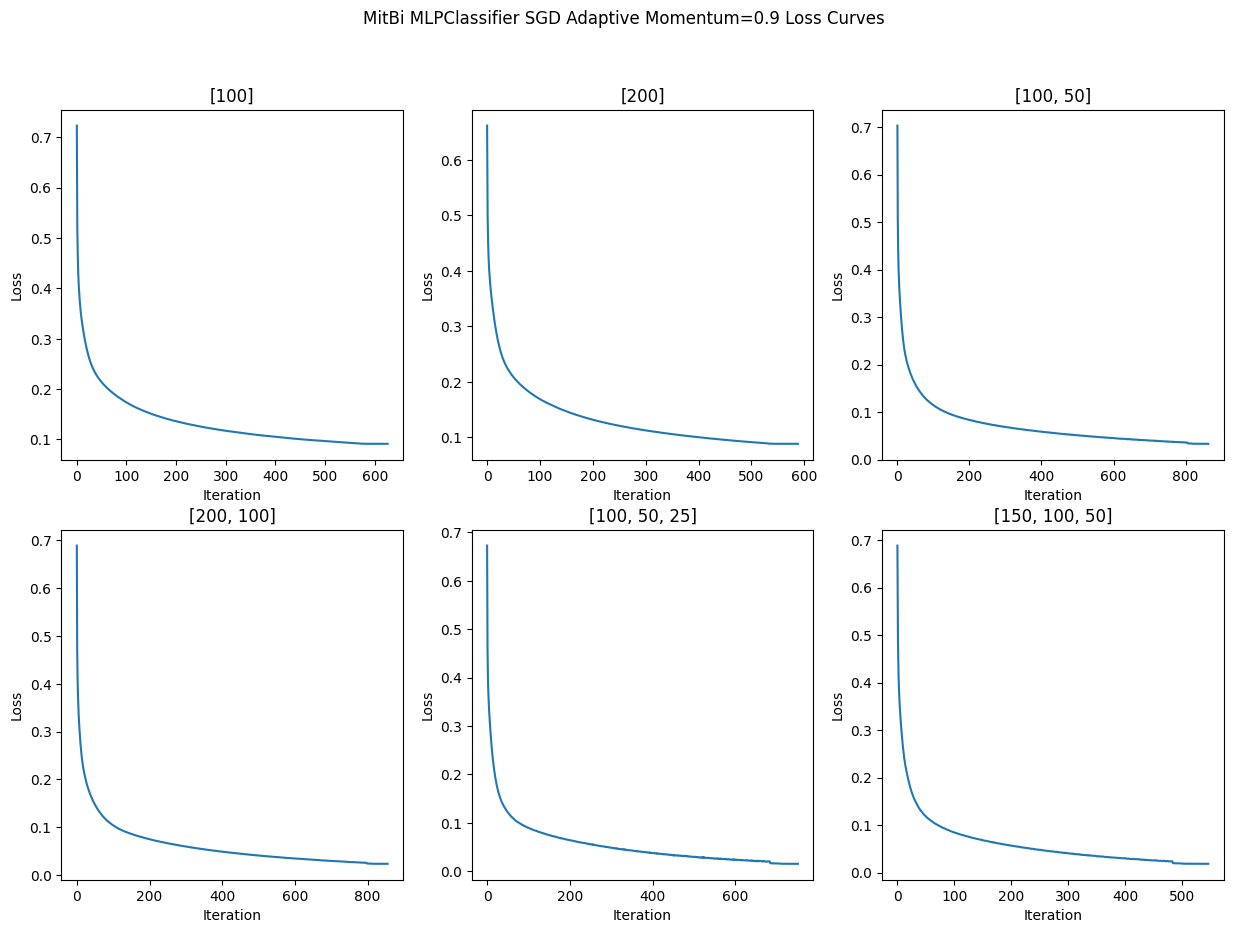

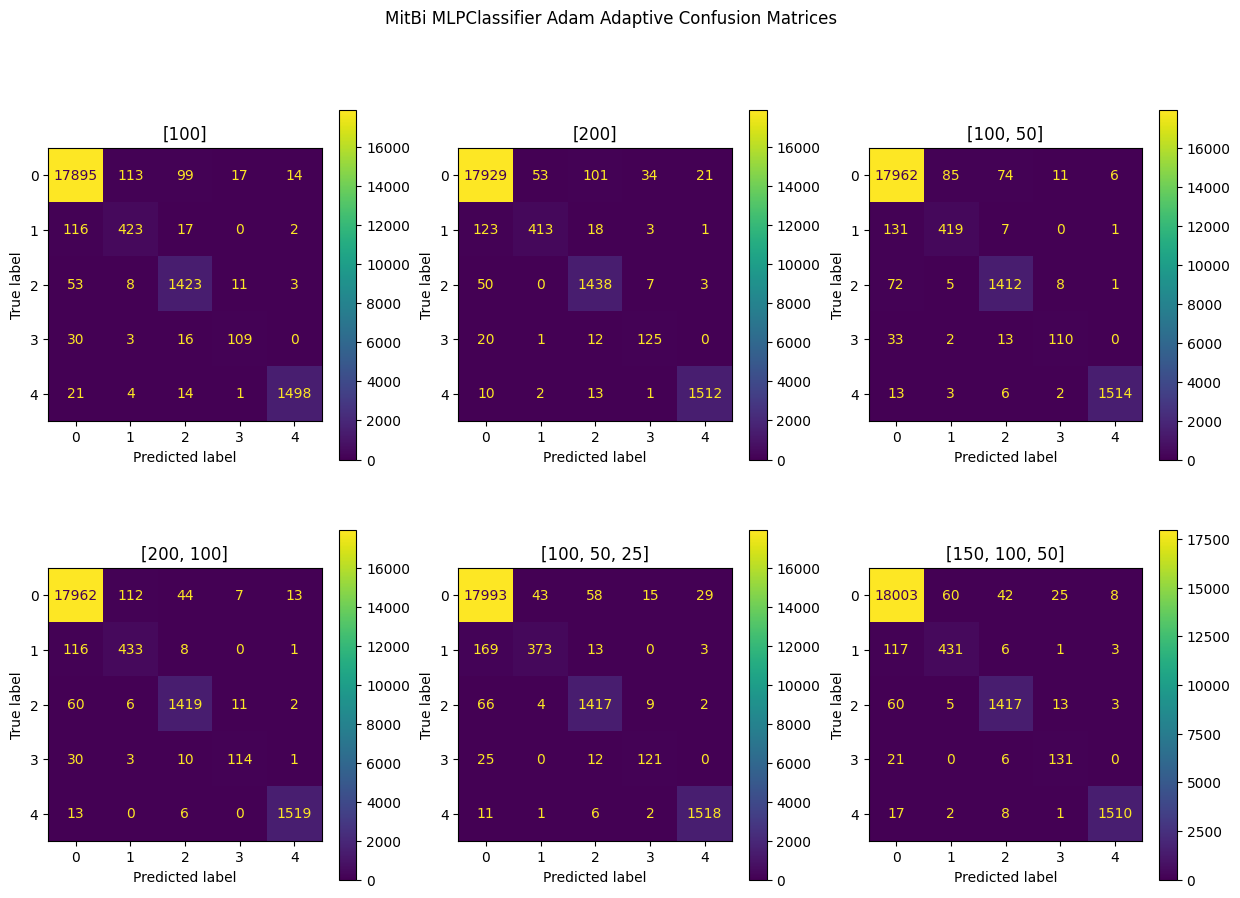

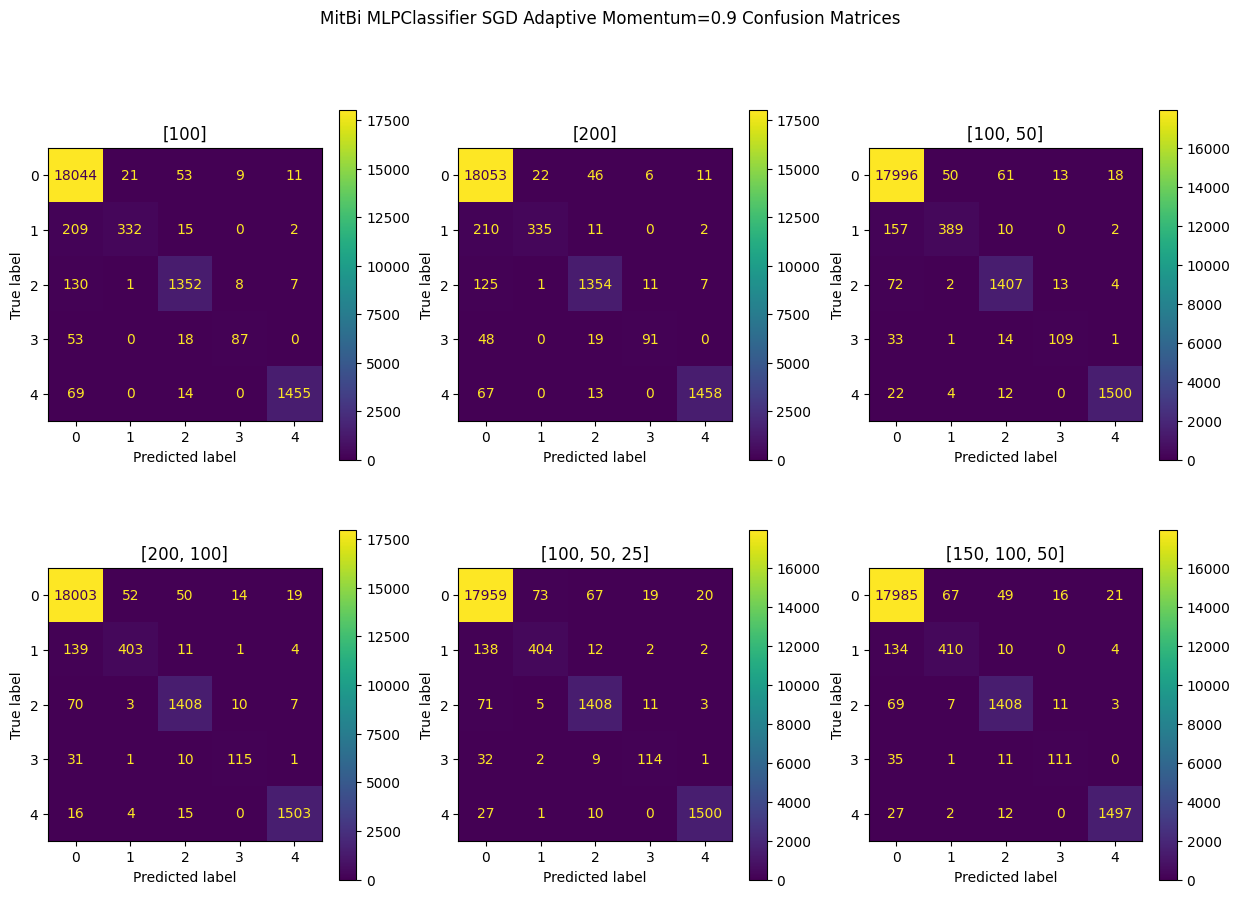

In [30]:
with open('mlp_stats.json', 'r') as f:
    stats = json.loads(f.read())

    for key in stats:
        for dataset in stats[key]:
            for i in range(len(stats[key][dataset])):
                stats[key][dataset][i]['confusion_matrix'] = np.array(stats[key][dataset][i]['confusion_matrix'])

possible_colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k']
models = list(stats.keys())

x = [f'{model} {hidden_layer_sizes}'  for model in models for hidden_layer_sizes in hidden_layer_sizes_list ]
colors = [possible_colors[models.index(model)] for model in models for _ in hidden_layer_sizes_list]
legend = [mpatches.Patch(color=possible_colors[i], label=models[i]) for i in range(len(models))]

for dataset in ['Patients', 'PTB', 'MitBi']:
    
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        y = []
        for model in models:
            y += [stat['metrics'][metric] * 100 for stat in stats[model][dataset]]

        plt.figure(figsize=(10, 5))
        plt.title(f'{dataset} MLPClassifier {metric.capitalize()}')
        plt.xlabel('Hidden Layer Sizes')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=90)
        plt.legend(handles=legend, loc='lower right')
        plt.bar(x, y, color=colors)
        plt.show()

    y = []
    for model in models:
        y += [stat['iterations'] for stat in stats[model][dataset]]

    plt.figure(figsize=(10, 5))
    plt.title(f'{dataset} MLPClassifier Iterations')
    plt.xlabel('Hidden Layer Sizes')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.legend(handles=legend, loc='lower right')
    plt.bar(x, y, color=colors)
    plt.show()

    for model in models:
        cols = 3
        rows = len(stats[model][dataset]) // cols if len(stats[model][dataset]) % cols == 0 else len(stats[model][dataset]) // cols + 1
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        fig.suptitle(f'{dataset} {model} Loss Curves')

        for i, stat in enumerate(stats[model][dataset]):
            axes[i // 3, i % 3].set_title(f'{stat["hidden_layer_sizes"]}')
            axes[i // 3, i % 3].set_xlabel('Iteration')
            axes[i // 3, i % 3].set_ylabel('Loss')
            axes[i // 3, i % 3].plot(stat['loss_curve'])

        for j in range(len(stats[model][dataset]), len(axes)):
            fig.delaxes(axes[j])
        
        plt.show()
    
    for model in models:
        cols = 3
        rows = len(stats[model][dataset]) // cols if len(stats[model][dataset]) % cols == 0 else len(stats[model][dataset]) // cols + 1
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        fig.suptitle(f'{dataset} {model} Confusion Matrices')

        for i, stat in enumerate(stats[model][dataset]):
            disp = ConfusionMatrixDisplay(confusion_matrix=stat['confusion_matrix'])
            axes[i // 3, i % 3].set_title(f'{stat["hidden_layer_sizes"]}')
            disp.plot(ax=axes[i // 3, i % 3])

## CNN

### Impartirea setului de date in date de test si train

In [10]:
ptbdb_x_train, ptbdb_x_test, ptbdb_y_train, ptbdb_y_test = train_test_split(ptbdb.drop(columns=['target']), ptbdb['target'], test_size=0.2)

### Antrenarea modelului si evaluarea performatelor

In [11]:
model = Sequential()

model.add(Input(shape=(ptbdb_x_train.shape[1], 1)))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

In [15]:
hist = model.fit(ptbdb_x_train, ptbdb_y_train, epochs=20, batch_size=32, validation_data=(ptbdb_x_test, ptbdb_y_test))

Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9743 - f1_score: 0.8362 - loss: 0.0697 - precision: 0.9816 - recall: 0.9827 - val_accuracy: 0.9869 - val_f1_score: 0.8379 - val_loss: 0.0422 - val_precision: 0.9891 - val_recall: 0.9929
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9757 - f1_score: 0.8352 - loss: 0.0696 - precision: 0.9832 - recall: 0.9829 - val_accuracy: 0.9797 - val_f1_score: 0.8379 - val_loss: 0.0602 - val_precision: 0.9885 - val_recall: 0.9833
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9781 - f1_score: 0.8408 - loss: 0.0606 - precision: 0.9816 - recall: 0.9883 - val_accuracy: 0.9866 - val_f1_score: 0.8379 - val_loss: 0.0481 - val_precision: 0.9868 - val_recall: 0.9948
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9781 - f1_score: 0.8395 - loss: 0.0602 - precision: 0.9830 - recall: 0.9868 - val_accuracy: 0.9852 - val_f1_score: 0.8379 - val_loss: 0.0477 - val_precision: 0.9914 - val_rec

In [16]:
eval = model.evaluate(ptbdb_x_test, ptbdb_y_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9913 - f1_score: 0.8382 - loss: 0.0405 - precision: 0.9891 - recall: 0.9989


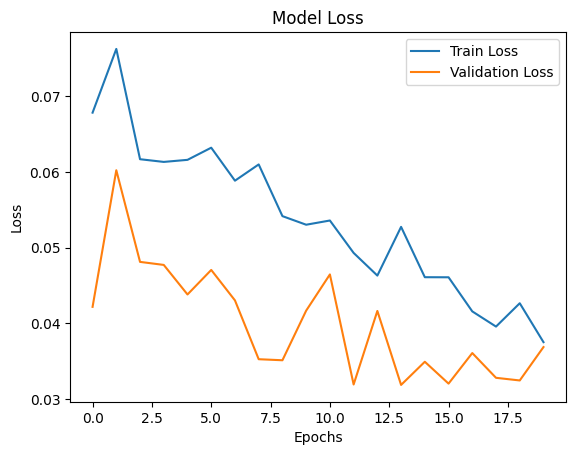

In [17]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()